In [1]:
%load_ext autoreload
%autoreload 2

import pandas as pd
from analysis import *
from getters import * 
from plotters import * 
from models.model_config import *

views=[0]
models=["gcn_student_ensamble_3"]
CV=["3Fold", "5Fold", "10Fold"]
run=0
dataset = "gender_data"

In [123]:
view_data_mean_1, _ = view_reproducibility_analysis(dataset, models, CV, views, run, students=[0], model_args=[gcn_student_ensamble_3_args_0_4])
view_data_mean_2, _ = view_reproducibility_analysis(dataset, models, CV, views, run, students=[1], model_args=[gcn_student_ensamble_3_args_0_4])
view_data_mean_3, _ = view_reproducibility_analysis(dataset, models, CV, views, run, students=[2], model_args=[gcn_student_ensamble_3_args_0_4])

In [5]:
view_data_mean_1, view_data_mean_2, view_data_mean_3

(array([[0.87777778, 0.87777778]]),
 array([[1., 1.]]),
 array([[0.96666667, 0.96666667]]))

In [2]:
def get_mean_CV_metric_student_model(dataset, model, analysis_type, training_type, view, run, student, dataset_split, model_args):

    import sklearn.metrics as metrics

    #get the mean metric for a student for a particular CV training_type 
    
    student_acc, student_recall, student_precision, student_f1 = 0, 0, 0, 0
    acc_mean, recall_mean, precision_mean, f1_mean = [], [], [], []
    
    if training_type == "3Fold":
        cv_number = 3
    if training_type == "5Fold":
        cv_number = 5
    if training_type == "10Fold":
        cv_number = 10  
    
    for i in range(cv_number):
        x = get_labels_and_preds(dataset=dataset, 
                                model=model,
                                analysis_type=analysis_type, 
                                training_type=training_type,  
                                cv_n=i, 
                                view=view, 
                                run=run, 
                                dataset_split=dataset_split, 
                                student=student, 
                                model_args=model_args)
        result = {
            'prec': metrics.precision_score(x['labels'],  x['preds']),
            'recall': metrics.recall_score(x['labels'],  x['preds']),
            'acc': metrics.accuracy_score(x['labels'],  x['preds']),
            'F1': metrics.f1_score(x['labels'],  x['preds'])
        }   
        acc_mean.append(result['acc'])
        recall_mean.append(result['recall'])
        precision_mean.append(result['prec'])
        f1_mean.append(result['F1'])
    
    student_acc = np.mean(acc_mean)
    student_recall = np.mean(recall_mean)
    student_precision = np.mean(precision_mean)
    student_f1 = np.mean(f1_mean)

    return student_acc, student_f1, student_recall, student_precision

In [3]:
def get_student_model_metric_all_folds(dataset, model, CV, runs, analysis_type, dataset_split, view, model_args):
    #Get average student modele metrics across all runs and all cv for all models in ensemble 
    """
    USAGE:
    runs = [i for i in range(10)]
    CV=["3Fold", "5Fold", "10Fold"]
    model = "gcn_student_ensamble_3"
    analysis_type="model_assessment"
    model_args= gcn_student_ensamble_args
    dataset_split="val"
    view=2

    get_student_model_metric_all_folds(dataset, model, CV, runs, analysis_type, dataset_split, view, model_args)
    """

    all_student_metrics_mean = []
    all_student_metrics_var = []

    for student in range(model_args["n_students"]):

        model_metrics_runs = []
        
        for run in runs:
                
            model_metrics = []
            
            for training_type in CV:
                
                model_metrics.append(get_mean_CV_metric_student_model(
                    dataset=dataset, 
                    model=model, 
                    analysis_type=analysis_type, 
                    training_type=training_type, 
                    view=view, 
                    run=run, 
                    student=student, 
                    dataset_split=dataset_split,
                    model_args=model_args
                )
                )
            
            model_metrics = np.mean(model_metrics, axis=0)
            model_metrics_runs.append(model_metrics)
        all_student_metrics_var.append(np.var(model_metrics_runs, axis=0))
        all_student_metrics_mean.append(np.mean(model_metrics_runs, axis=0))

    return all_student_metrics_mean, all_student_metrics_var


In [4]:
def get_best_student_ensamble(model, view, CV, runs, dataset_split, analysis_type, model_args):
    import warnings
    warnings.filterwarnings('ignore')
    
    student_rep = []
    student_var = []

    # get the best reproducibility across all runs 
    for run in runs:

        mean_all_runs = []

        for student in range(model_args["n_students"]):
            view_rep, _ = view_reproducibility_analysis(
                dataset=dataset, 
                models=[model], 
                CV=CV, 
                views=[view], 
                run=run, 
                students=[student], 
                model_args=[model_args]
            )
            mean_all_runs.append(view_rep[0][0])
        #store the reproducibility score for all students for the run 
        student_rep.append(mean_all_runs)
    
    #get the mean and variance for the reproducibility scores for all the students
    student_var = np.var(student_rep, axis=0)
    student_rep = np.mean(student_rep, axis=0)

    #get the metrics of all the student models
    all_student_metrics_mean, _ = get_student_model_metric_all_folds(
        dataset=dataset, 
        model=model, 
        CV=CV, 
        runs=runs, 
        analysis_type=analysis_type, 
        dataset_split=dataset_split, 
        view=view, 
        model_args=model_args
    )
    
    #get the best model based soley on max reproducibility 
    best_rep_max = 0
    metric = 0
    student_max = -1
    for i, rep in enumerate(student_rep):
        if rep > metric:
            best_rep_max = rep 
            metric = rep
            student_max = i

    #get the best model based on max reproducibility and accuracy
    best_rep_acc = 0
    metric = 0
    student_acc_index = -1
    for i, rep in enumerate(student_rep):
        student_acc = all_student_metrics_mean[i][0]
        if (rep+student_acc)/2 > metric:
            metric = (rep+student_acc)/2 
            best_rep_acc = rep
            student_acc_index = i
    
    #get the best model based on max reproducibility and f1 score
    best_rep_f1 = 0
    metric = 0
    student_f1_index = -1
    for i, rep in enumerate(student_rep):
        student_f1 = all_student_metrics_mean[i][1]
        if (rep+student_f1)/2 > metric:
            metric = (rep+student_f1)/2 
            best_rep_f1 = rep
            student_f1_index = i
    
    return [best_rep_max, student_var[student_max], student_max], [best_rep_acc, student_var[student_acc_index], student_acc_index], [best_rep_f1, student_var[student_f1_index], student_f1_index]
    

# FIND THE BEST STUDENT IN ENSAMBLE 

In [95]:
analysis_type="model_assessment"
dataset_split="val"

for view in [0,2,4,5]:
    print(get_best_student_ensamble(
        model="gcn_student_ensamble_3", 
        view=view, 
        CV=CV,
        runs=[i for i in range(10)], 
        analysis_type=analysis_type,
        dataset_split=dataset_split,
        model_args=gcn_student_ensamble_3_args
    ))

([0.96875, 1.8229166666666675e-05, 2], [0.96875, 1.8229166666666675e-05, 2], [0.96875, 1.8229166666666675e-05, 2])
([0.9320833333333335, 0.0008103587962962955, 0], [0.9320833333333335, 0.0008103587962962955, 0], [0.8823611111111112, 0.00030904706790123553, 1])
([0.9577777777777776, 0.00010655864197530909, 2], [0.9577777777777776, 0.00010655864197530909, 2], [0.9577777777777776, 0.00010655864197530909, 2])
([0.9486111111111111, 0.0003387345679012343, 0], [0.9126388888888888, 0.0003250192901234564, 1], [0.9126388888888888, 0.0003250192901234564, 1])


## Overview of the models and ensamble 

In [5]:
def get_student_model_metric(dataset, model, CV, runs, analysis_type, dataset_split, view, model_args):
    #Get average student modele metrics across all runs and all cv for all models in ensemble 
    #EACH FOLD INDIVIDUAL

    student_data_mean = [] 
    student_data_var = [] 
    
    for student in range(model_args["n_students"]):

        run_data = []   

        for run in runs:

            model_metrics = []
            
            for training_type in CV:

                model_cv_metrics = get_mean_CV_metric_student_model(
                    dataset=dataset, 
                    model=model, 
                    analysis_type=analysis_type, 
                    training_type=training_type, 
                    view=view, 
                    run=run, 
                    student=student, 
                    dataset_split=dataset_split,
                    model_args=model_args
                    )
                model_metrics.append(model_cv_metrics)
            
            run_data.append(model_metrics)
        
        student_data_mean.append(np.mean(run_data, axis=0))   
        student_data_var.append(np.std(run_data, axis=0))        

    return student_data_mean, student_data_var

In [6]:
def get_model_metric(dataset, model, CV, runs, analysis_type, dataset_split, view, model_args):
    #Get average metrics across all runs and all cv for any model 
    #EACH FOLD INDIVIDUAL

    data_mean = [] 
    data_var = [] 

    run_data = []   


    for run in runs:

        model_metrics = []
        
        for training_type in CV:
            
            model_cv_metrics = get_mean_CV_metric_student_model(
                dataset=dataset, 
                model=model, 
                analysis_type=analysis_type, 
                training_type=training_type, 
                view=view, 
                run=run, 
                student=-1, 
                dataset_split=dataset_split,
                model_args=model_args
                )
            model_metrics.append(model_cv_metrics)
        
        run_data.append(model_metrics)
        
    data_mean.append(np.mean(run_data, axis=0))   
    data_var.append(np.std(run_data, axis=0))        

    return data_mean, data_var

In [46]:
views=[0, 2, 4, 5]

gcn_args = {
    "num_epochs":50, 
    "lr": 0.0001,
    "weight_decay":5e-4, 
    "hidden_dim":64,
    "dropout":0,
    "threshold":"median", # Threshold the graph adjacency matrix. Possible values: no_threshold, median, mean
    "model_name":"gcn",
    "layers":2,
    "evaluation_method": "model_assessment" # model selection or model assessment
}

gcn_student_args = {
    "num_epochs":50, 
    "lr": 0.0001, 
    "weight_decay":5e-4, 
    "hidden_dim":64,
    "dropout":0,
    "threshold":"median", # Threshold the graph adjacency matrix. Possible values: no_threshold, median, mean
    "model_name":"gcn_student",
    "evaluation_method": "model_assessment", # model selection or model assessment
    "alpha_ce": 1, 
    "T": 3, 
    "alpha_soft_ce": 2,
    "alpha_weight": 0
}
#models=["gcn", "gcn_student", "gcn_student_teacher"]
CV=["3Fold", "5Fold", "10Fold"]
model = "gcn_student_ensamble_3"
runs = [i for i in range(9)]
dataset = "gender_data"
dataset_split="val"
analysis_type="model_assessment"
metrics = ["acc", "f1", "recall", "precision"]
model_args= gcn_student_ensamble_3_args
for view in views:

    mean, std = get_student_model_metric(dataset, model, CV, runs, analysis_type, dataset_split, view, model_args) 
    mean_gcn, std_gcn = get_model_metric(dataset=dataset, model="gcn", CV=CV, runs=runs, analysis_type=analysis_type, dataset_split=dataset_split, view=view, model_args=gcn_args)
    mean_gcn_student, std_gcn_student = get_model_metric(dataset=dataset, model="gcn_student", CV=CV, runs=runs, analysis_type=analysis_type, dataset_split=dataset_split, view=view, model_args=gcn_student_args)
    mean_gcn_ts, std_gcn_ts = get_model_metric(dataset=dataset, model="gcn_student_teacher", CV=CV, runs=runs, analysis_type=analysis_type, dataset_split=dataset_split, view=view, model_args=gcn_student_args)
    
    for i, metric in enumerate(metrics):
        print("____________________________________________________")
        print(f"View: {view} Metric: {metric}")        
        
        mean_df = pd.DataFrame(np.array(mean)[:,:,i], columns=CV, index=["Student 1", "Student 2", "Student 3"]).round(3)
        std_df = pd.DataFrame(np.array(std)[:,:,i], columns=CV, index=["Student 1", "Student 2", "Student 3"]).round(3)
        
        mean_gcn_df = pd.DataFrame(np.array(mean_gcn)[:,:,i], columns=CV, index=["GCN"]).round(3)
        std_gcn_df = pd.DataFrame(np.array(std_gcn)[:,:,i], columns=CV, index=["GCN"]).round(3)

        mean_gcn_student_df = pd.DataFrame(np.array(mean_gcn_student)[:,:,i], columns=CV, index=["GCN Student"]).round(3)
        std_gcn_student_df = pd.DataFrame(np.array(std_gcn_student)[:,:,i], columns=CV, index=["GCN Student"]).round(3)

        mean_gcn_ts_df = pd.DataFrame(np.array(mean_gcn_ts)[:,:,i], columns=CV, index=["Vanilla KD"]).round(3)
        std_gcn_ts_df = pd.DataFrame(np.array(std_gcn_ts)[:,:,i], columns=CV, index=["Vanilla KD"]).round(3)
        
        final_mean_df = pd.concat([mean_gcn_df, mean_gcn_student_df, mean_gcn_ts_df, mean_df])
        final_var_df = pd.concat([std_gcn_df, std_gcn_student_df, std_gcn_ts_df, std_df])

        print(final_mean_df.astype(str) + u"\u00B1" + final_var_df.astype(str))

KeyError: 'backbone'

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


____________________________________________________
View: 0 Metric: acc


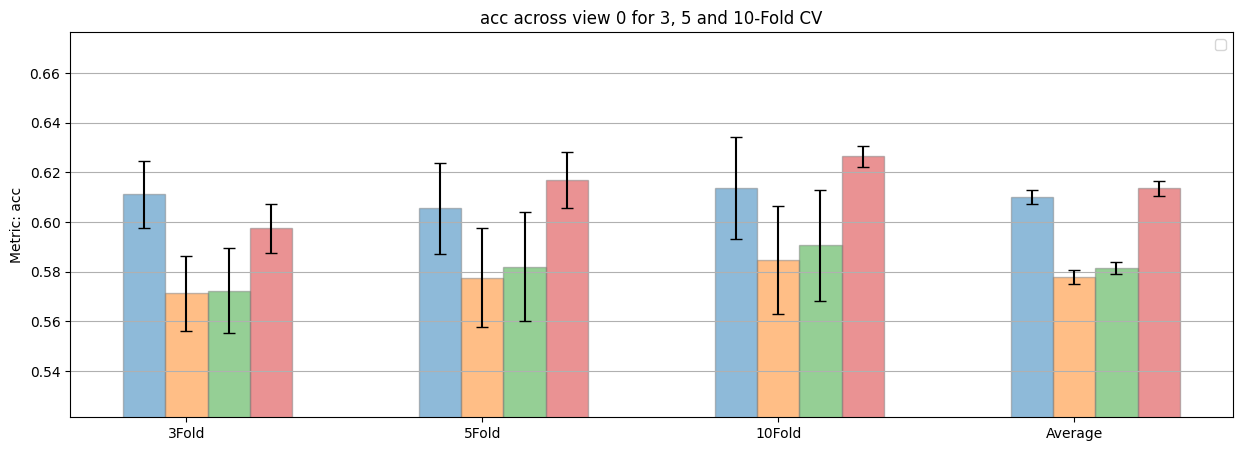

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


____________________________________________________
View: 2 Metric: acc


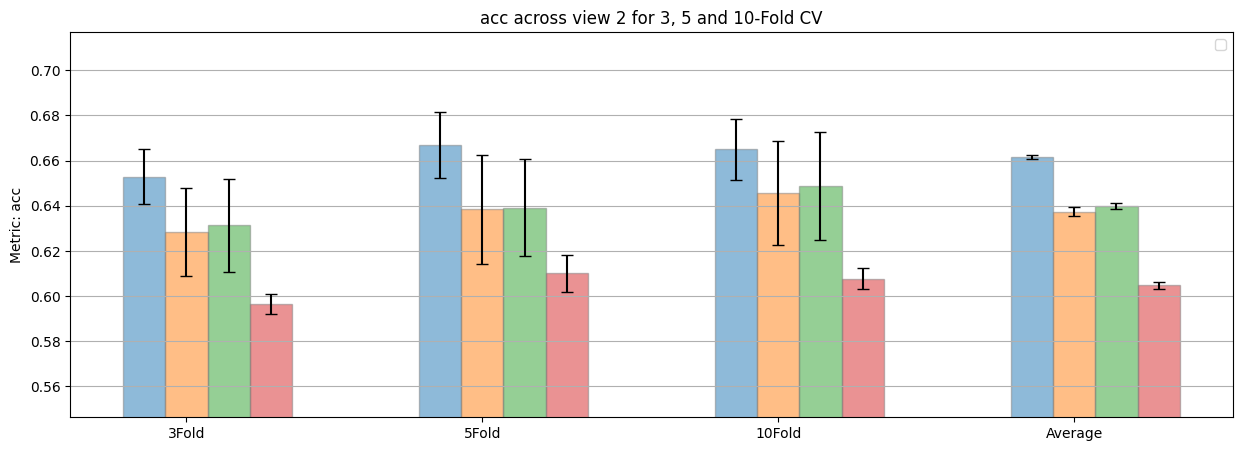

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


____________________________________________________
View: 4 Metric: acc


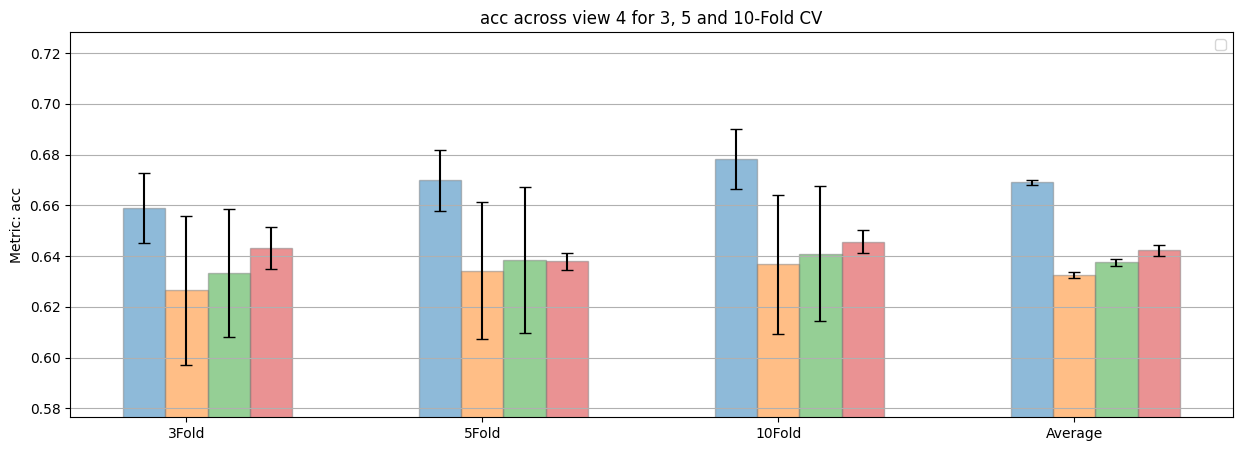

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


____________________________________________________
View: 5 Metric: acc


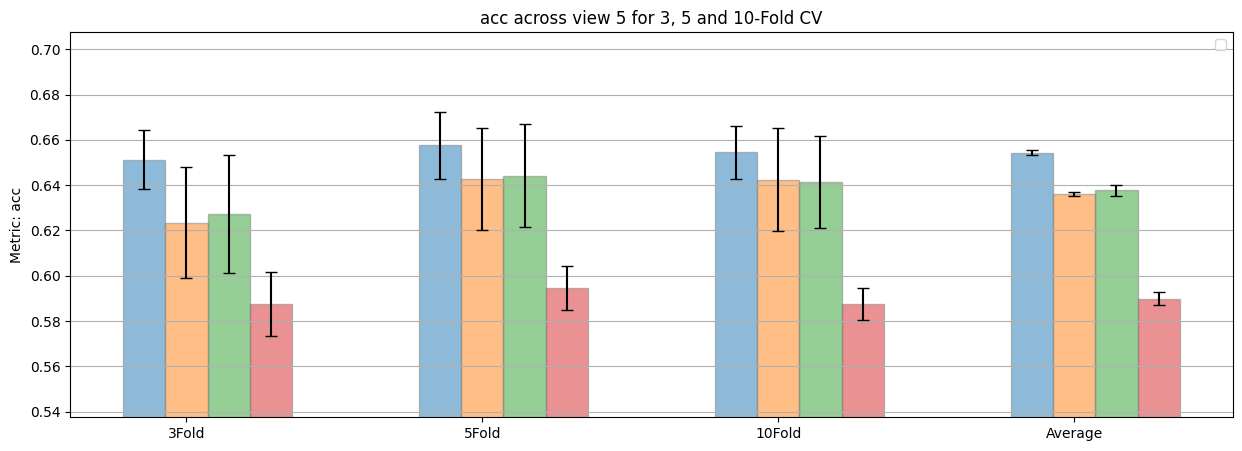

<Figure size 1500x500 with 0 Axes>

In [69]:
from models.model_config import *
views=[0, 2, 4, 5]
#models=["gcn", "gcn_student", "gcn_student_teacher"]
CV=["3Fold", "5Fold", "10Fold"]
model = "gcn_student_ensamble_3"
runs = [i for i in range(10)]
dataset = "gender_data"
dataset_split="val"
analysis_type="model_assessment"
metrics = ["acc"]
model_args= gcn_student_ensamble_3_args
best_student = [2,0,2,0]

for best_student_i, view in enumerate(views):

    models = ["gcn", "gcn_student", "gcn_student_teacher"]
    mean_all_runs = []
    for run in [i for i in range(10)]:
        view_data_mean, _ = view_metric_analysis(models=models, 
                                                 CV=CV, view=view, 
                                                 run=run, 
                                                 metric="acc", 
                                                 dataset=dataset, 
                                                 dataset_split=dataset_split, 
                                                 analysis_type=analysis_type,
                                                 model_args=[gcn_args, gcn_student_args, gcn_student_args])
        mean_all_runs.append(view_data_mean)

    mean_all_std = np.std(mean_all_runs, axis=0).squeeze()
    mean_all_runs = np.mean(mean_all_runs, axis=0).squeeze()

    index_student = best_student[best_student_i]

    mean, std = get_student_model_metric(dataset, model, CV, runs, analysis_type, dataset_split, view, model_args)
    mean = mean[index_student]
    std = std[index_student]
    
    for i, metric in enumerate(metrics):
        print("____________________________________________________")
        print(f"View: {view} Metric: {metric}")        
        
        mean_df = np.array(mean)[:,i]
        mean_df = mean_df[np.newaxis, :]
        
        std_df = np.array(std)[:,i]
        std_df = std_df[np.newaxis, :]
        
        final_mean_df = np.r_[mean_all_runs, mean_df]
        final_var_df = np.r_[mean_all_std, std_df]

        barWidth = 1/7
        
        #GET MEAN AND STD ACROSS MEAN OF RUNS

        mean_all_runs = np.c_[ final_mean_df, np.mean(final_mean_df, axis=1)]     
        mean_all_std = np.c_[ final_var_df, np.std(final_var_df, axis=1)]  
        
        X = np.arange(len(CV)+1)
        sep = 0.00
        for j, view_d in enumerate(mean_all_runs):
            plt.bar(X + sep, view_d, yerr=mean_all_std[j], capsize=4, width = barWidth, edgecolor ='grey', alpha=0.5)
            sep += barWidth
        
        max_y_lim = np.amax(mean_all_runs) + 0.05
        min_y_lim = np.amin(mean_all_runs) - 0.05
        plt.ylim(min_y_lim, max_y_lim)
        
        #title = f"Dataset:{dataset}, Metric:{metric}, View:{view}, Across: {len(runs)} seeds with fixed init"
        title = f"{metric} across view {view} for 3, 5 and 10-Fold CV"
        
        plt.ylabel(f"Metric: {metric}")
        x_ticks = [i for i in CV]+ ["Average"]
        
        plt.xticks([r + barWidth for r in range(len(CV)+1)], x_ticks)
        plt.title(title)
        plt.grid(axis = 'y')
        plt.legend()
        plt.show()
        plt.clf()   

# REPRODUCIBILITY

In [569]:
def view_reproducibility_analysis_student_specific(dataset, models, CV, views, run, students=[0], model_args=None):
    """
    Reproducibility analysis for a single run for specific students in ensamble 
    student length = number of views, it is the specific student for each view
    """

    view_data_mean = []
    view_data_std = []

    for i, view in enumerate(views):
        
        model_result_mean = []
        model_result_std = []
        ensamble_count = 0

        for j, model in enumerate(models):

            rep_score, std = view_specific_rep(dataset=dataset, view=view, model=model, run=run, CV=CV, student=students[ensamble_count][i], model_args=model_args[j])
            model_result_mean.append(rep_score)
            model_result_std.append(std)
            
            if "ensamble" in models:
                ensamble_count += 1

        view_data_mean.append(model_result_mean)
        view_data_std.append(model_result_std)

    view_data_std.append(list(np.std(view_data_mean, axis=0)))
    view_data_std = np.array(view_data_std).T

    view_data_mean.append(list(np.mean(view_data_mean, axis=0)))

    view_data_mean = np.array(view_data_mean).T
    
    return view_data_mean, view_data_std 

In [8]:
def plot_bar_chart_reproducibility_mulitple_runs_student_specific(dataset, views, models, CV, runs, students=0, model_args=None, save_fig=False):
    """
    USAGE:
    plot_bar_chart_reproducibility_mulitple_runs_student_specific(
    dataset="gender_data", 
    views=[0, 2, 4, 5], 
    models=[  
        "gcn", 
        "gcn_student",
        "gcn_student_teacher",
        "gcn_student_ensamble_3", 
    ], 
    CV=["3Fold", "5Fold", "10Fold"], 
    runs=[i for i in range(10)], 
    students=[2,0,2,0], 
    model_args= [
        gcn_args,
        gcn_student_args,
        gcn_student_args,
        gcn_student_ensamble_args,
    ], 
    save_fig=False
    )
    """
    plt.rcParams["figure.figsize"] = (15,5)

    barWidth = 1/(len(models)+1)

    mean_all_runs = []
    views=[0, 2, 4, 5]
    runs=[i for i in range(10)]
    for run in runs:
        view_data_mean, _ = view_reproducibility_analysis_student_specific(dataset, models, CV, views, run, students=students, model_args=model_args)
        mean_all_runs.append(view_data_mean)

    mean_all_std = np.std(mean_all_runs, axis=0)
    mean_all_runs = np.mean(mean_all_runs, axis=0)
    
    X = np.arange(len(views)+1)

    sep = 0.00
    for i, view_d in enumerate(mean_all_runs):
        if models[i] == "gcn":
            plt.bar(X + sep, view_d, yerr=mean_all_std[i], capsize=4, width = barWidth, edgecolor ='grey', label=models[i]+"_teacher", alpha=0.5)
        elif models[i] == "gcn_student_ensamble_3":
            plt.bar(X + sep, view_d, yerr=mean_all_std[i], capsize=4, width = barWidth, edgecolor ='grey', label="best_student_ensemble", alpha=0.5)
        else:
            plt.bar(X + sep, view_d, yerr=mean_all_std[i], capsize=4, width = barWidth, edgecolor ='grey', label=models[i], alpha=0.5)
        
        sep += barWidth

    max_y_lim = 1 if np.amax(mean_all_runs) + np.max(mean_all_std) > 1 else np.amax(mean_all_runs) + np.max(mean_all_std)
    min_y_lim = 0 if np.amin(mean_all_runs) - np.max(mean_all_std) - 0.01 < 0 else np.amin(mean_all_runs) - np.max(mean_all_std) - 0.01
    plt.ylim(min_y_lim, max_y_lim)

    title = f"Reproducibility Score for Dataset:{dataset} across {len(runs)} different seeds for best student"

    plt.ylabel("Reproducibility Score")
    x_ticks = ["View {}".format(i) for i in views]+ ["Average"]

    plt.xticks([r + barWidth for r in range(len(mean_all_runs[0]))], x_ticks)
    plt.title(title)
    plt.grid(axis = 'y')
    plt.legend()
    if save_fig:
        if not os.path.exists(SAVE_DIR_FIGS+"reproducibility/"):
            os.makedirs(SAVE_DIR_FIGS+"reproducibility/")
        
        plt.savefig(SAVE_DIR_FIGS+"reproducibility/"+title+".png", dpi=150)
        plt.clf()
    
    else:
        plt.show()
        plt.clf()  

In [85]:
plot_bar_chart_reproducibility_mulitple_runs_student_specific(
    dataset="gender_data", 
    views=[0, 2, 4, 5], 
    models=[  
        "gcn", 
        "gcn_student",
        "gcn_student_teacher",
        "fitnet", 
        "lsp", 
        "mskd",
        "gcn_student_ensamble_3", 
    ], 
    CV=["3Fold", "5Fold", "10Fold"], 
    runs=[i for i in range(10)], 
    students=[2,0,2,0], 
    model_args= [
        gcn_args,
        gcn_student_args,
        gcn_student_args, 
        fitnet_student_args, 
        lsp_student_args, 
        mskd_student_args,
        gcn_student_ensamble_3_args,
    ], 
    save_fig=False)

KeyboardInterrupt: 

In [42]:
plot_bar_chart_reproducibility_mulitple_runs_student_specific(
    dataset="gender_data", 
    views=[0, 2, 4, 5], 
    models=[  
        "gcn", 
        "gcn_student",
        "gcn_student_teacher",
        "fitnet", 
        "lsp", 
        "mskd",
        "gcn_student_ensamble_3", 
    ], 
    CV=["3Fold", "5Fold", "10Fold"], 
    runs=[i for i in range(10)], 
    students=[2,1,2,1], 
    model_args= [
        gcn_args,
        gcn_student_args,
        gcn_student_args, 
        fitnet_student_args, 
        lsp_student_args, 
        mskd_student_args,
        gcn_student_ensamble_3_args,
    ], 
    save_fig=False)

KeyError: 'backbone'

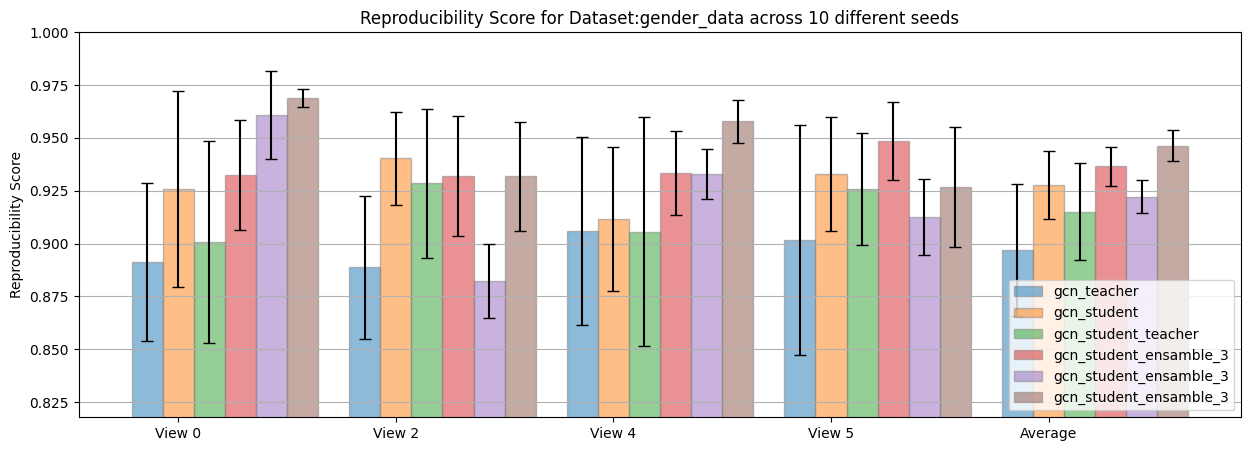

<Figure size 1500x500 with 0 Axes>

In [22]:
plot_bar_chart_reproducibility_mulitple_runs(dataset="gender_data", 
                                             views=[0, 2, 4, 5], 
                                             models=[  "gcn", 
                                                       "gcn_student",
                                                       "gcn_student_teacher",
                                                       "gcn_student_ensamble_3", 
                                                       "gcn_student_ensamble_3", 
                                                       "gcn_student_ensamble_3"
                                                    ], 
                                             students=[-1, -1, -1, 0, 1, 2],
                                             CV=["3Fold", "5Fold", "10Fold"], 
                                             runs=[i for i in range(10)], 
                                             model_args = [
                                                 gcn_args,
                                                 gcn_student_args,
                                                 gcn_student_args,
                                                 gcn_student_ensamble_3_args_0_4,
                                                 gcn_student_ensamble_3_args_0_4,
                                                 gcn_student_ensamble_3_args_0_4
                                             ],
                                             save_fig=False)

# ANALYSIS 2 ENSAMBLE

In [74]:
analysis_type="model_assessment"
dataset_split="val"

for view in [0,2,4,5]:
    print(get_best_student_ensamble(
        model="gcn_student_ensamble_2", 
        view=view, 
        CV=CV,
        runs=[i for i in range(10)], 
        analysis_type=analysis_type,
        dataset_split=dataset_split,
        model_args=gcn_student_ensamble_2_args
    ))

([0.9405555555555555, 0.000494135802469136, 0], [0.9405555555555555, 0.000494135802469136, 0], [0.9156944444444445, 0.0005571180555555544, 1])
([0.9297222222222221, 0.0003584876543209886, 0], [0.9297222222222221, 0.0003584876543209886, 0], [0.8902777777777778, 0.0001358024691358015, 1])
([0.943888888888889, 0.0006798611111111126, 1], [0.943888888888889, 0.0006798611111111126, 1], [0.943888888888889, 0.0006798611111111126, 1])
([0.946111111111111, 0.000361419753086421, 1], [0.946111111111111, 0.000361419753086421, 1], [0.946111111111111, 0.000361419753086421, 1])


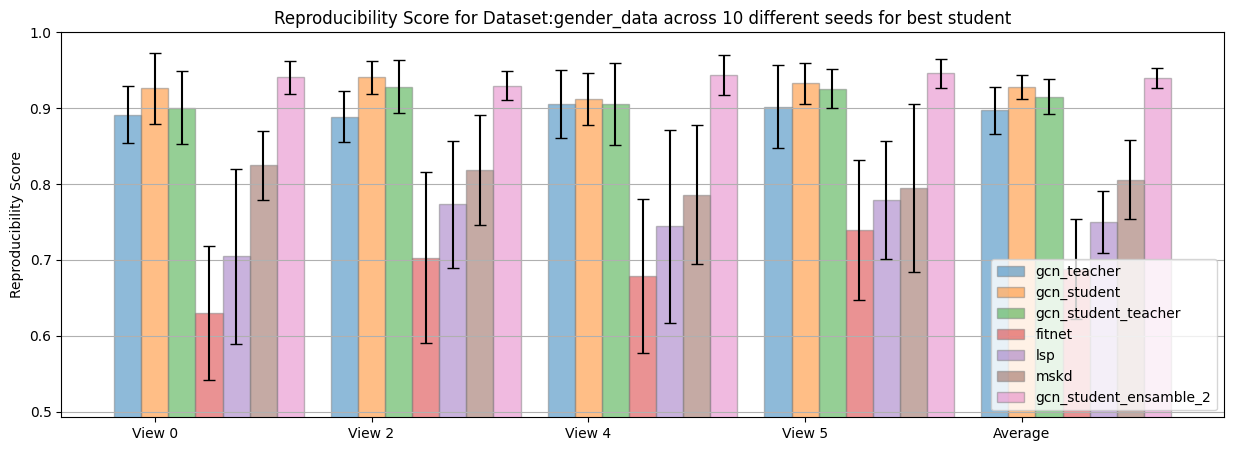

<Figure size 1500x500 with 0 Axes>

In [75]:
plot_bar_chart_reproducibility_mulitple_runs_student_specific(
    dataset="gender_data", 
    views=[0, 2, 4, 5], 
    models=[  
        "gcn", 
        "gcn_student",
        "gcn_student_teacher",
        "fitnet", 
        "lsp", 
        "mskd",
        "gcn_student_ensamble_2", 
    ], 
    CV=["3Fold", "5Fold", "10Fold"], 
    runs=[i for i in range(10)], 
    students=[0,0,1,1], 
    model_args= [
        gcn_args,
        gcn_student_args,
        gcn_student_args, 
        fitnet_student_args, 
        lsp_student_args, 
        mskd_student_args,
        gcn_student_ensamble_2_args,
    ], 
    save_fig=False)

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


____________________________________________________
View: 0 Metric: acc


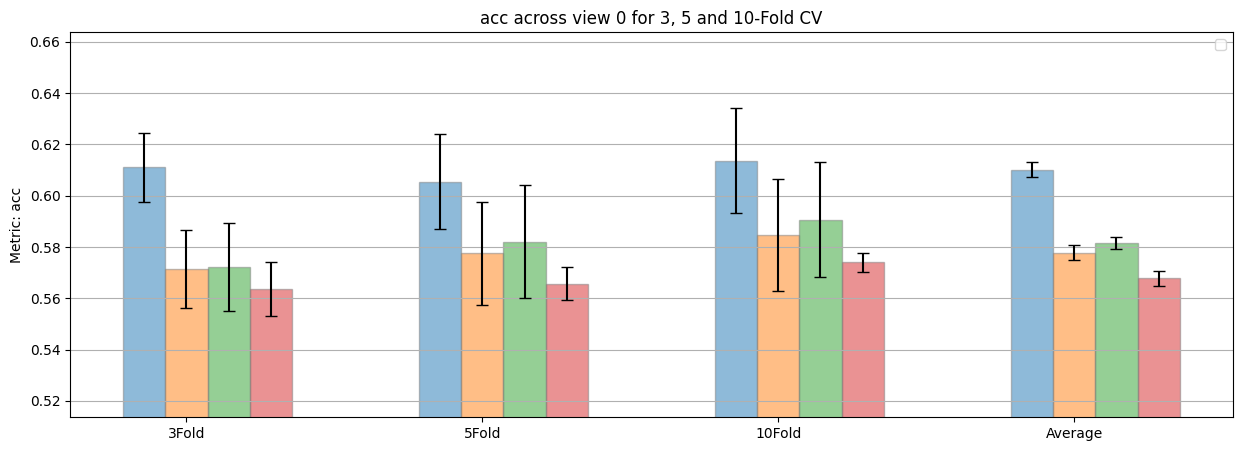

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


____________________________________________________
View: 2 Metric: acc


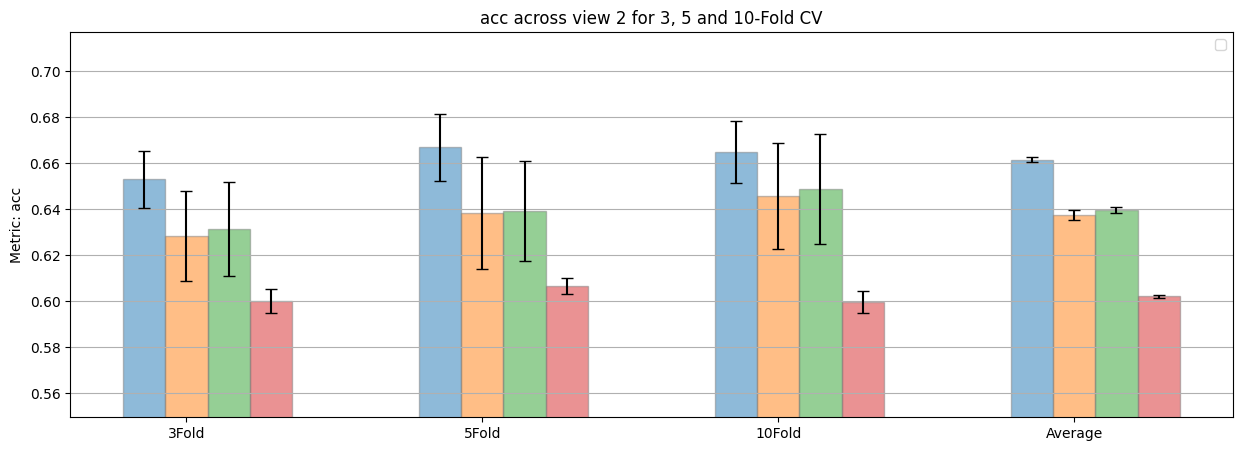

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


____________________________________________________
View: 4 Metric: acc


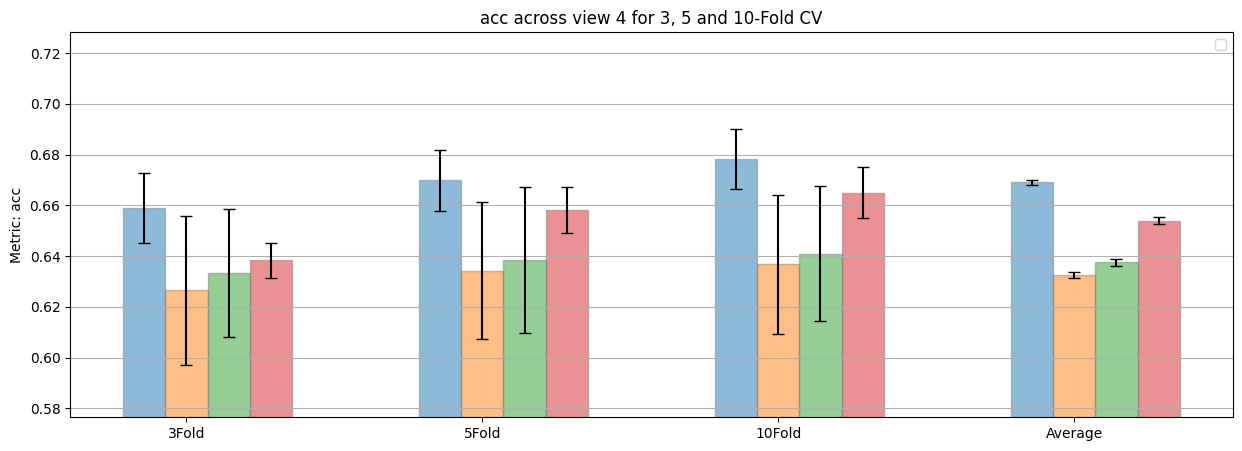

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


____________________________________________________
View: 5 Metric: acc


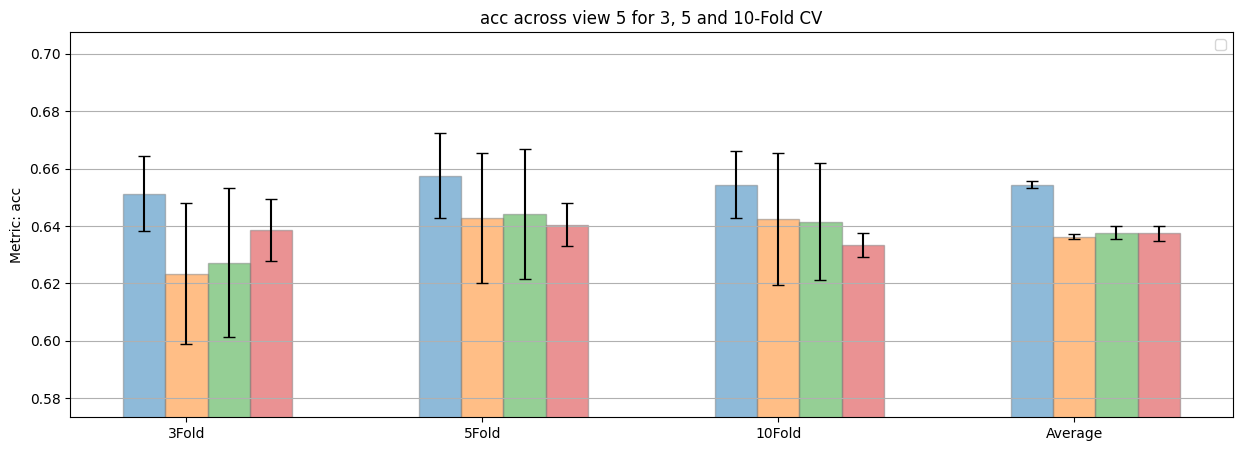

<Figure size 1500x500 with 0 Axes>

In [106]:
from models.model_config import *
views=[0, 2, 4, 5]
#models=["gcn", "gcn_student", "gcn_student_teacher"]
CV=["3Fold", "5Fold", "10Fold"]
model = "gcn_student_ensamble_2"
runs = [i for i in range(10)]
dataset = "gender_data"
dataset_split="val"
analysis_type="model_assessment"
metrics = ["acc"]
model_args= gcn_student_ensamble_2_args
best_student = [0,0,1,1]

for best_student_i, view in enumerate(views):

    models = ["gcn", "gcn_student", "gcn_student_teacher"]
    mean_all_runs = []
    for run in [i for i in range(10)]:
        view_data_mean, _ = view_metric_analysis(models=models, 
                                                 CV=CV, view=view, 
                                                 run=run, 
                                                 metric="acc", 
                                                 dataset=dataset, 
                                                 dataset_split=dataset_split, 
                                                 analysis_type=analysis_type,
                                                 model_args=[gcn_args, gcn_student_args, gcn_student_args])
        mean_all_runs.append(view_data_mean)

    mean_all_std = np.std(mean_all_runs, axis=0).squeeze()
    mean_all_runs = np.mean(mean_all_runs, axis=0).squeeze()

    index_student = best_student[best_student_i]

    mean, std = get_student_model_metric(dataset, model, CV, runs, analysis_type, dataset_split, view, model_args)
    mean = mean[index_student]
    std = std[index_student]
    
    for i, metric in enumerate(metrics):
        print("____________________________________________________")
        print(f"View: {view} Metric: {metric}")        
        
        mean_df = np.array(mean)[:,i]
        mean_df = mean_df[np.newaxis, :]
        
        std_df = np.array(std)[:,i]
        std_df = std_df[np.newaxis, :]
        
        final_mean_df = np.r_[mean_all_runs, mean_df]
        final_var_df = np.r_[mean_all_std, std_df]

        barWidth = 1/7
        
        #GET MEAN AND STD ACROSS MEAN OF RUNS

        mean_all_runs = np.c_[ final_mean_df, np.mean(final_mean_df, axis=1)]     
        mean_all_std = np.c_[ final_var_df, np.std(final_var_df, axis=1)]  
        
        X = np.arange(len(CV)+1)
        sep = 0.00
        for j, view_d in enumerate(mean_all_runs):
            plt.bar(X + sep, view_d, yerr=mean_all_std[j], capsize=4, width = barWidth, edgecolor ='grey', alpha=0.5)
            sep += barWidth
        
        max_y_lim = np.amax(mean_all_runs) + 0.05
        min_y_lim = np.amin(mean_all_runs) - 0.05
        plt.ylim(min_y_lim, max_y_lim)
        
        #title = f"Dataset:{dataset}, Metric:{metric}, View:{view}, Across: {len(runs)} seeds with fixed init"
        title = f"{metric} across view {view} for 3, 5 and 10-Fold CV"
        
        plt.ylabel(f"Metric: {metric}")
        x_ticks = [i for i in CV]+ ["Average"]
        
        plt.xticks([r + barWidth for r in range(len(CV)+1)], x_ticks)
        plt.title(title)
        plt.grid(axis = 'y')
        plt.legend()
        plt.show()
        plt.clf()   

# ANALYSIS 4 ENSAMBLE

In [131]:
analysis_type="model_assessment"
dataset_split="val"

for view in [0,2,4,5]:
    print(get_best_student_ensamble(
        model="gcn_student_ensamble_4", 
        view=view, 
        CV=CV,
        runs=[i for i in range(10)], 
        analysis_type=analysis_type,
        dataset_split=dataset_split,
        model_args=gcn_student_ensamble_4_args
    )
)

([0.9722222222222223, 0.00029629629629629727, 2], [0.9722222222222223, 0.00029629629629629727, 2], [0.9722222222222223, 0.00029629629629629727, 2])
([0.9530555555555557, 0.0005111111111111117, 1], [0.9530555555555557, 0.0005111111111111117, 1], [0.9530555555555557, 0.0005111111111111117, 1])
([0.961111111111111, 0.00013888888888888835, 2], [0.961111111111111, 0.00013888888888888835, 2], [0.961111111111111, 0.00013888888888888835, 2])
([0.9552777777777777, 0.0001380401234567913, 1], [0.9552777777777777, 0.0001380401234567913, 1], [0.9552777777777777, 0.0001380401234567913, 1])


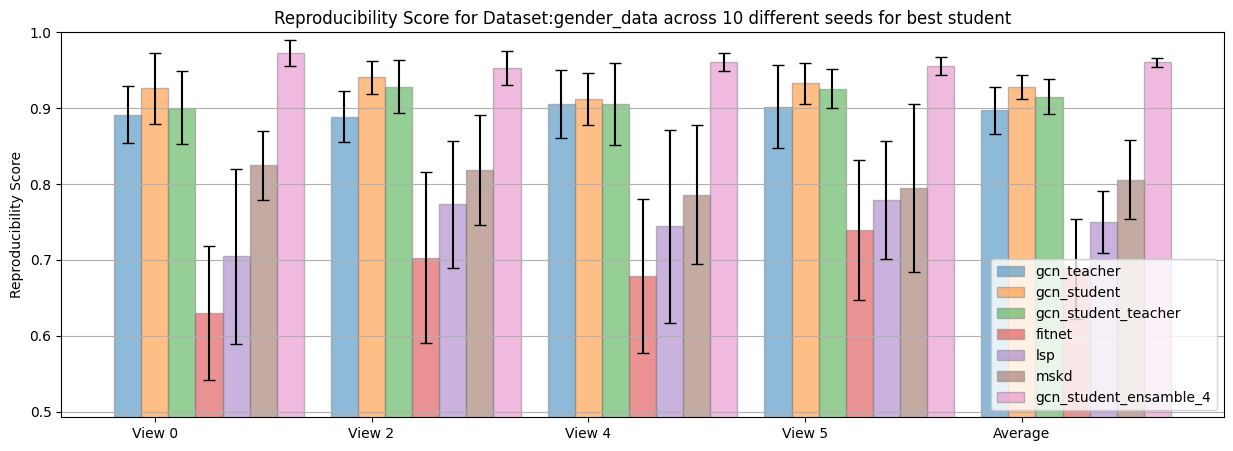

<Figure size 1500x500 with 0 Axes>

In [132]:
plot_bar_chart_reproducibility_mulitple_runs_student_specific(
    dataset="gender_data", 
    views=[0, 2, 4, 5], 
    models=[  
        "gcn", 
        "gcn_student",
        "gcn_student_teacher",
        "fitnet", 
        "lsp", 
        "mskd",
        "gcn_student_ensamble_4", 
    ], 
    CV=["3Fold", "5Fold", "10Fold"], 
    runs=[i for i in range(10)], 
    students=[2,1,2,1], 
    model_args= [
        gcn_args,
        gcn_student_args,
        gcn_student_args, 
        fitnet_student_args, 
        lsp_student_args, 
        mskd_student_args,
        gcn_student_ensamble_4_args,
    ], 
    save_fig=False)

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


____________________________________________________
View: 0 Metric: acc


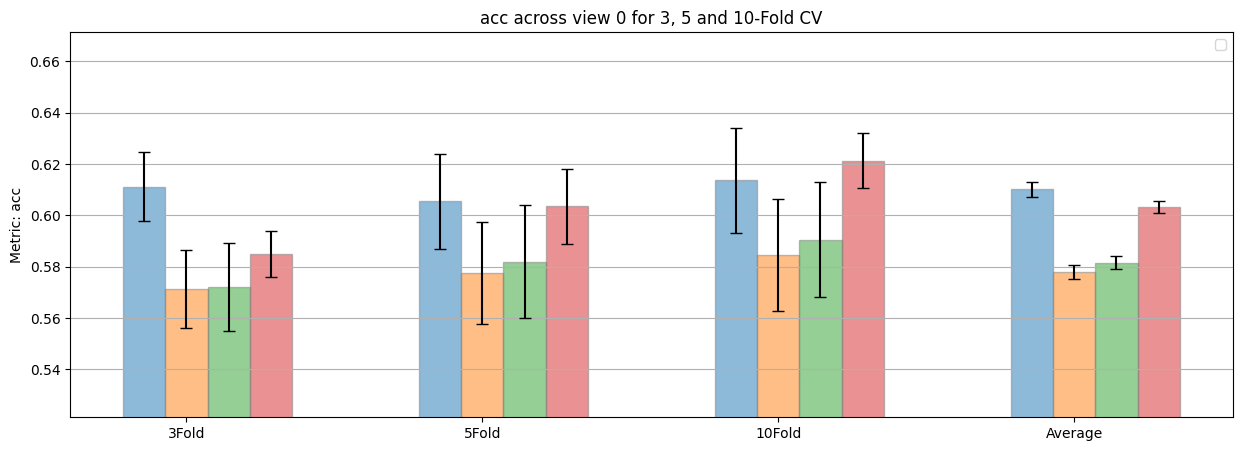

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


____________________________________________________
View: 2 Metric: acc


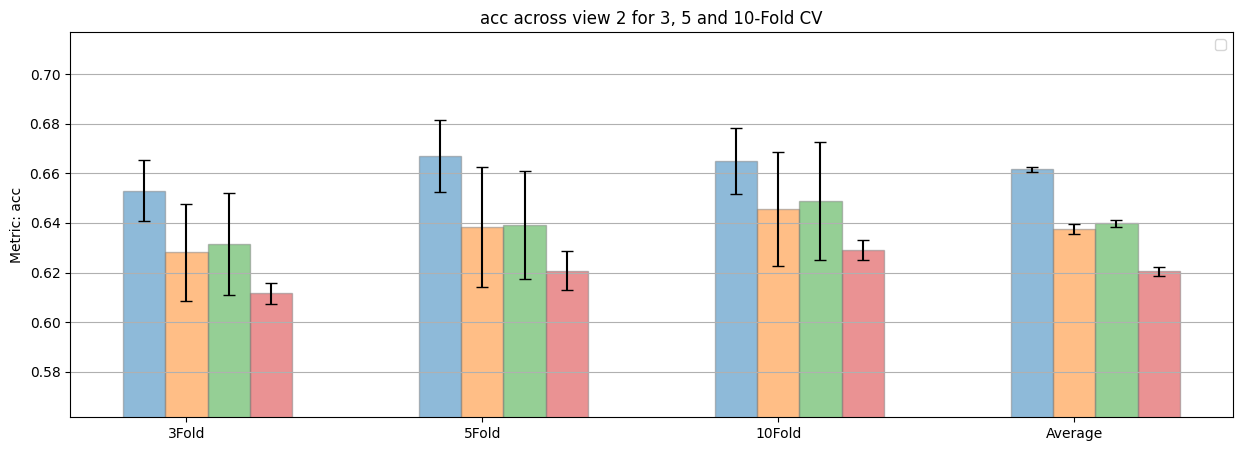

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


____________________________________________________
View: 4 Metric: acc


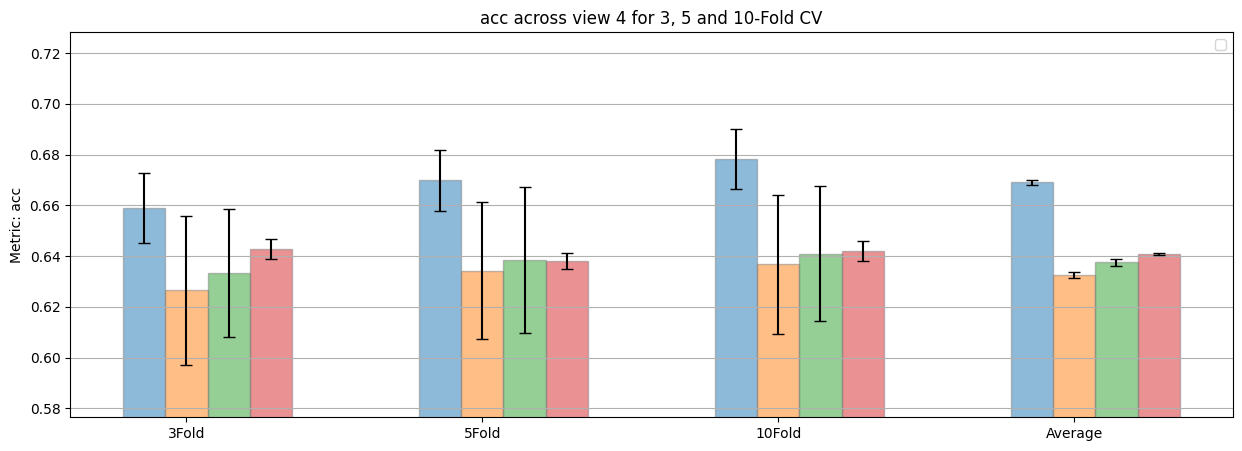

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


____________________________________________________
View: 5 Metric: acc


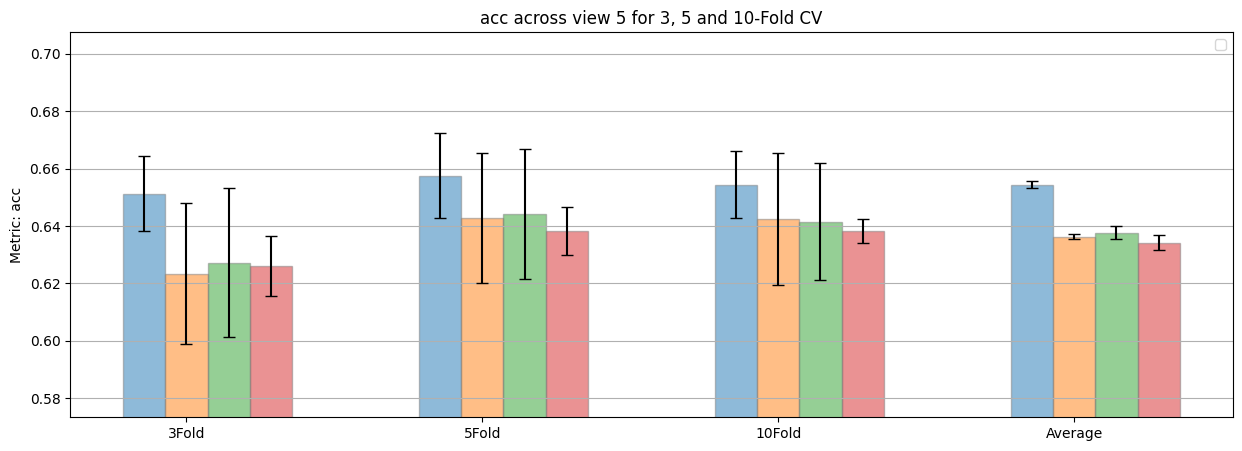

<Figure size 1500x500 with 0 Axes>

In [133]:
from models.model_config import *

views=[0, 2, 4, 5]
CV=["3Fold", "5Fold", "10Fold"]
model = "gcn_student_ensamble_4"
runs = [i for i in range(10)]
dataset = "gender_data"
dataset_split="val"
analysis_type="model_assessment"
metrics = ["acc"]
model_args= gcn_student_ensamble_4_args
best_student = [2,1,2,1]

for best_student_i, view in enumerate(views):

    models = ["gcn", "gcn_student", "gcn_student_teacher"]
    mean_all_runs = []
    for run in [i for i in range(10)]:
        view_data_mean, _ = view_metric_analysis(models=models, 
                                                 CV=CV, view=view, 
                                                 run=run, 
                                                 metric="acc", 
                                                 dataset=dataset, 
                                                 dataset_split=dataset_split, 
                                                 analysis_type=analysis_type,
                                                 model_args=[gcn_args, gcn_student_args, gcn_student_args])
        mean_all_runs.append(view_data_mean)

    mean_all_std = np.std(mean_all_runs, axis=0).squeeze()
    mean_all_runs = np.mean(mean_all_runs, axis=0).squeeze()

    index_student = best_student[best_student_i]

    mean, std = get_student_model_metric(dataset, model, CV, runs, analysis_type, dataset_split, view, model_args)
    mean = mean[index_student]
    std = std[index_student]
    
    for i, metric in enumerate(metrics):
        print("____________________________________________________")
        print(f"View: {view} Metric: {metric}")        
        
        mean_df = np.array(mean)[:,i]
        mean_df = mean_df[np.newaxis, :]
        
        std_df = np.array(std)[:,i]
        std_df = std_df[np.newaxis, :]
        
        final_mean_df = np.r_[mean_all_runs, mean_df]
        final_var_df = np.r_[mean_all_std, std_df]

        barWidth = 1/7
        
        #GET MEAN AND STD ACROSS MEAN OF RUNS

        mean_all_runs = np.c_[ final_mean_df, np.mean(final_mean_df, axis=1)]     
        mean_all_std = np.c_[ final_var_df, np.std(final_var_df, axis=1)]  
        
        X = np.arange(len(CV)+1)
        sep = 0.00
        for j, view_d in enumerate(mean_all_runs):
            plt.bar(X + sep, view_d, yerr=mean_all_std[j], capsize=4, width = barWidth, edgecolor ='grey', alpha=0.5)
            sep += barWidth
        
        max_y_lim = np.amax(mean_all_runs) + 0.05
        min_y_lim = np.amin(mean_all_runs) - 0.05
        plt.ylim(min_y_lim, max_y_lim)
        
        #title = f"Dataset:{dataset}, Metric:{metric}, View:{view}, Across: {len(runs)} seeds with fixed init"
        title = f"{metric} across view {view} for 3, 5 and 10-Fold CV"
        
        plt.ylabel(f"Metric: {metric}")
        x_ticks = [i for i in CV]+ ["Average"]
        
        plt.xticks([r + barWidth for r in range(len(CV)+1)], x_ticks)
        plt.title(title)
        plt.grid(axis = 'y')
        plt.legend()
        plt.show()
        plt.clf()   

# ANALYSIS 5 ENSAMBLE

In [105]:
analysis_type="model_assessment"
dataset_split="val"

for view in [0,2,4,5]:
    print(get_best_student_ensamble(
        model="gcn_student_ensamble_5", 
        view=view, 
        CV=CV,
        runs=[i for i in range(10)], 
        analysis_type=analysis_type,
        dataset_split=dataset_split,
        model_args=gcn_student_ensamble_5_args
    )
)

([0.9668055555555555, 0.0004932291666666668, 1], [0.9652777777777779, 0.0005883487654321007, 2], [0.8848611111111111, 0.00023937114197530914, 4])
([0.9677777777777777, 0.00029660493827160506, 2], [0.9416666666666668, 0.0002472993827160485, 3], [0.9120833333333331, 0.0009656828703703679, 4])
([0.9755555555555555, 0.00021111111111111076, 2], [0.9755555555555555, 0.00021111111111111076, 2], [0.9755555555555555, 0.00021111111111111076, 2])
([0.9597222222222221, 0.0005636574074074058, 2], [0.9377777777777776, 0.00037415123456790094, 3], [0.9377777777777776, 0.00037415123456790094, 3])


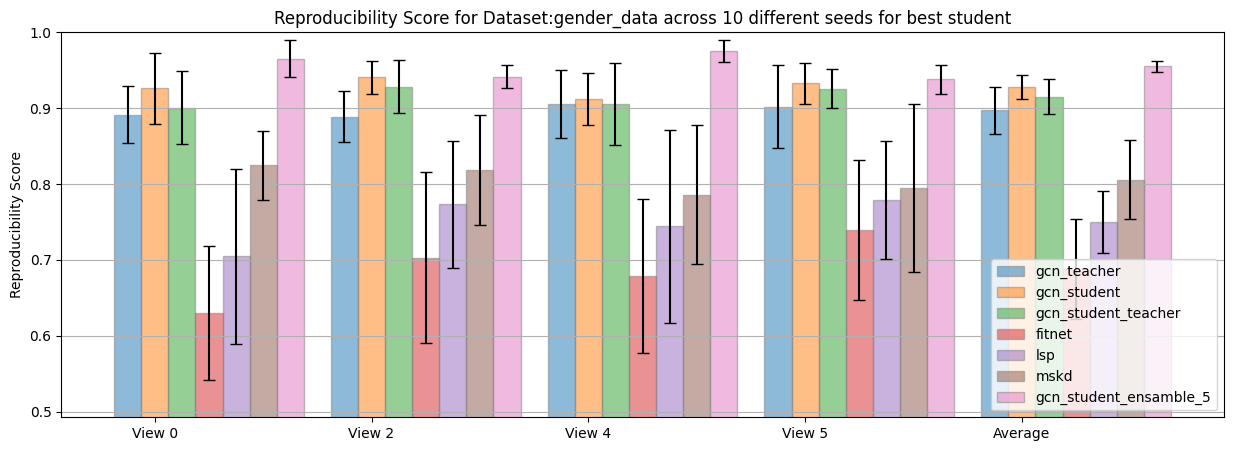

<Figure size 1500x500 with 0 Axes>

In [107]:
plot_bar_chart_reproducibility_mulitple_runs_student_specific(
    dataset="gender_data", 
    views=[0, 2, 4, 5], 
    models=[  
        "gcn", 
        "gcn_student",
        "gcn_student_teacher",
        "fitnet", 
        "lsp", 
        "mskd",
        "gcn_student_ensamble_5", 
    ], 
    CV=["3Fold", "5Fold", "10Fold"], 
    runs=[i for i in range(10)], 
    students=[2,3,2,3], 
    model_args= [
        gcn_args,
        gcn_student_args,
        gcn_student_args, 
        fitnet_student_args, 
        lsp_student_args, 
        mskd_student_args,
        gcn_student_ensamble_5_args,
    ], 
    save_fig=False)

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


____________________________________________________
View: 0 Metric: acc


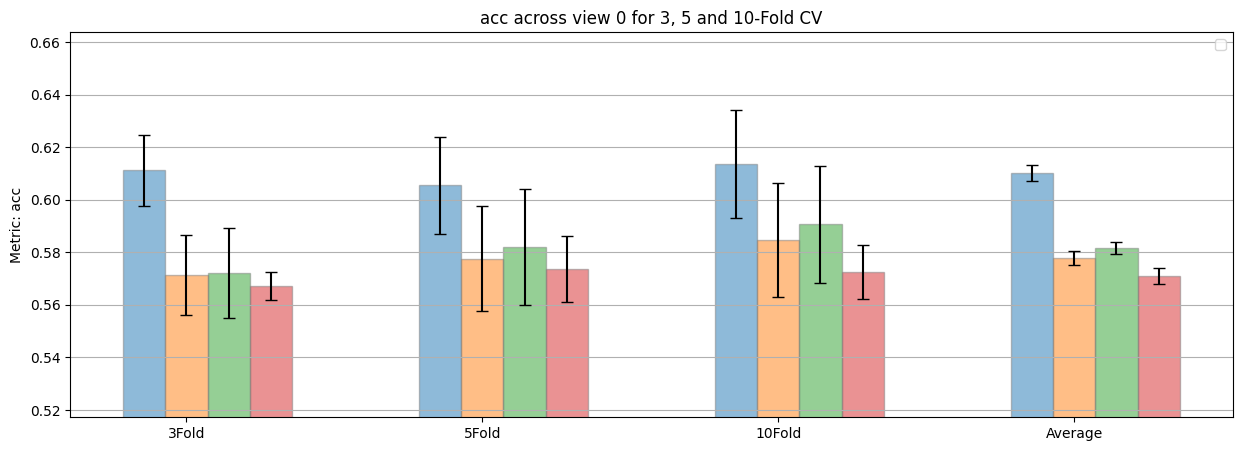

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


____________________________________________________
View: 2 Metric: acc


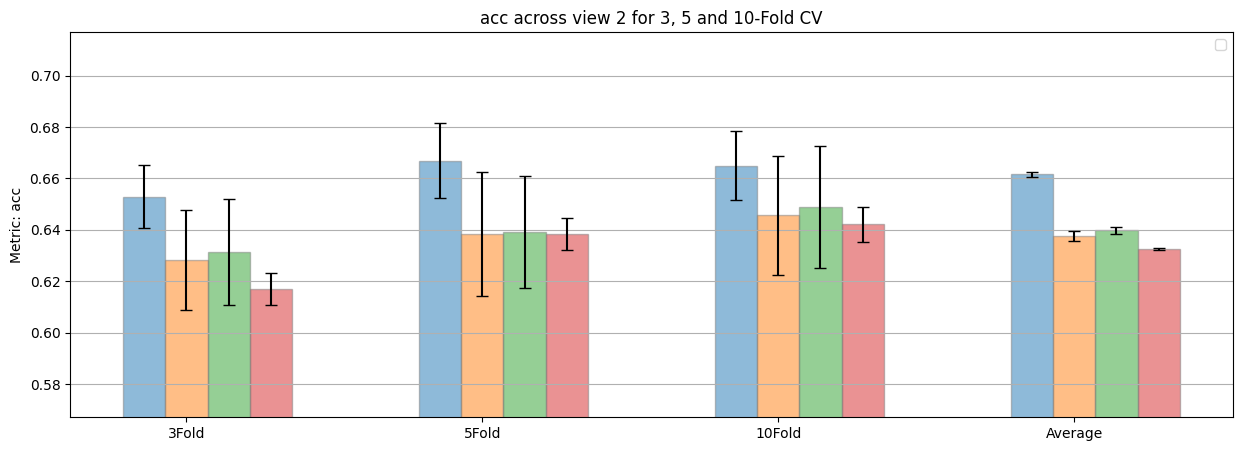

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


____________________________________________________
View: 4 Metric: acc


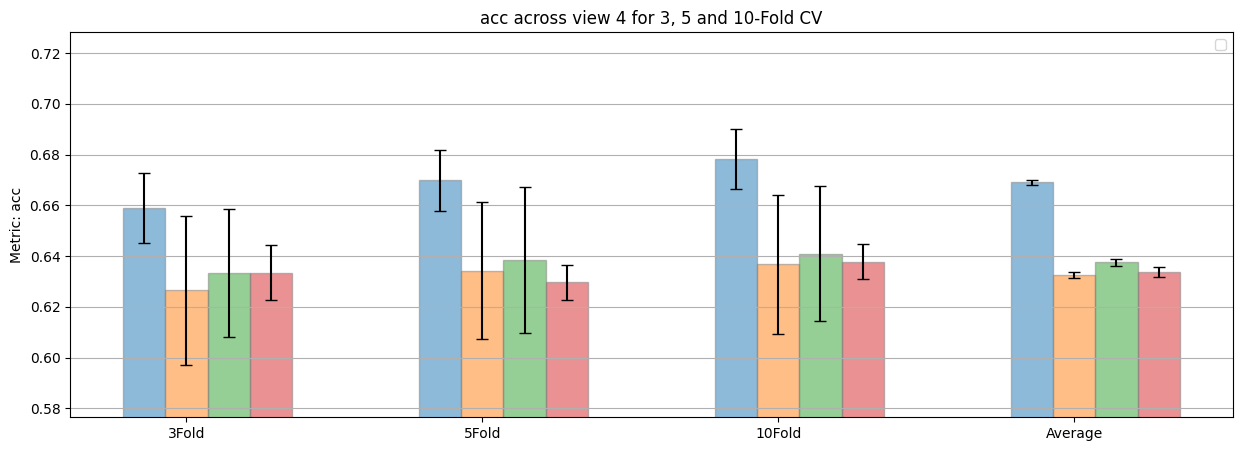

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


____________________________________________________
View: 5 Metric: acc


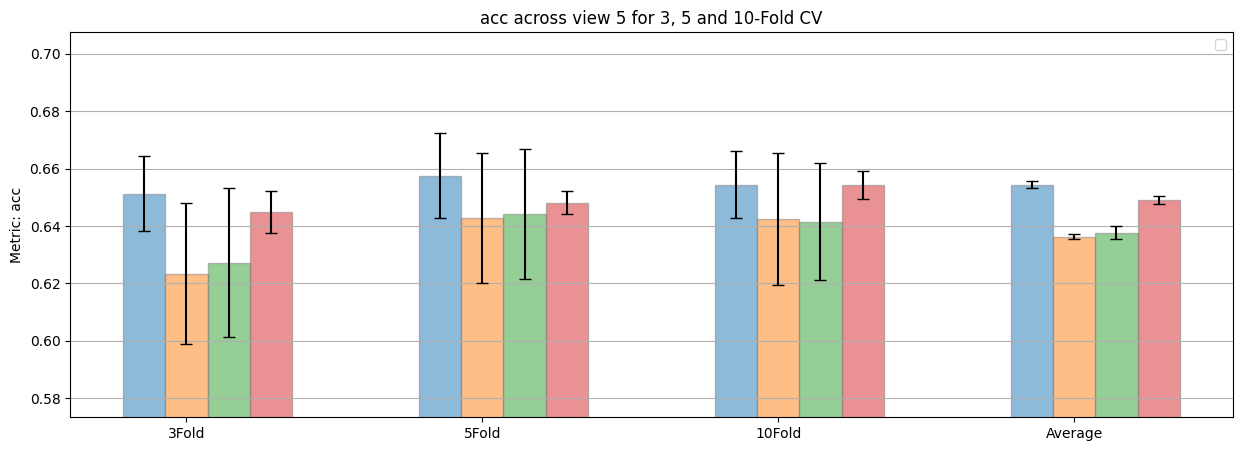

<Figure size 1500x500 with 0 Axes>

In [108]:
from models.model_config import *

views=[0, 2, 4, 5]
CV=["3Fold", "5Fold", "10Fold"]
model = "gcn_student_ensamble_5"
runs = [i for i in range(10)]
dataset = "gender_data"
dataset_split="val"
analysis_type="model_assessment"
metrics = ["acc"]
model_args= gcn_student_ensamble_5_args
best_student = [2,3,2,3]

for best_student_i, view in enumerate(views):

    models = ["gcn", "gcn_student", "gcn_student_teacher"]
    mean_all_runs = []
    for run in [i for i in range(10)]:
        view_data_mean, _ = view_metric_analysis(models=models, 
                                                 CV=CV, view=view, 
                                                 run=run, 
                                                 metric="acc", 
                                                 dataset=dataset, 
                                                 dataset_split=dataset_split, 
                                                 analysis_type=analysis_type,
                                                 model_args=[gcn_args, gcn_student_args, gcn_student_args])
        mean_all_runs.append(view_data_mean)

    mean_all_std = np.std(mean_all_runs, axis=0).squeeze()
    mean_all_runs = np.mean(mean_all_runs, axis=0).squeeze()

    index_student = best_student[best_student_i]

    mean, std = get_student_model_metric(dataset, model, CV, runs, analysis_type, dataset_split, view, model_args)
    mean = mean[index_student]
    std = std[index_student]
    
    for i, metric in enumerate(metrics):
        print("____________________________________________________")
        print(f"View: {view} Metric: {metric}")        
        
        mean_df = np.array(mean)[:,i]
        mean_df = mean_df[np.newaxis, :]
        
        std_df = np.array(std)[:,i]
        std_df = std_df[np.newaxis, :]
        
        final_mean_df = np.r_[mean_all_runs, mean_df]
        final_var_df = np.r_[mean_all_std, std_df]

        barWidth = 1/7
        
        #GET MEAN AND STD ACROSS MEAN OF RUNS

        mean_all_runs = np.c_[ final_mean_df, np.mean(final_mean_df, axis=1)]     
        mean_all_std = np.c_[ final_var_df, np.std(final_var_df, axis=1)]  
        
        X = np.arange(len(CV)+1)
        sep = 0.00
        for j, view_d in enumerate(mean_all_runs):
            plt.bar(X + sep, view_d, yerr=mean_all_std[j], capsize=4, width = barWidth, edgecolor ='grey', alpha=0.5)
            sep += barWidth
        
        max_y_lim = np.amax(mean_all_runs) + 0.05
        min_y_lim = np.amin(mean_all_runs) - 0.05
        plt.ylim(min_y_lim, max_y_lim)
        
        #title = f"Dataset:{dataset}, Metric:{metric}, View:{view}, Across: {len(runs)} seeds with fixed init"
        title = f"{metric} across view {view} for 3, 5 and 10-Fold CV"
        
        plt.ylabel(f"Metric: {metric}")
        x_ticks = [i for i in CV]+ ["Average"]
        
        plt.xticks([r + barWidth for r in range(len(CV)+1)], x_ticks)
        plt.title(title)
        plt.grid(axis = 'y')
        plt.legend()
        plt.show()
        plt.clf()   

# ENSEMBLE ANLAYISIS

In [134]:
# get the best reproducibility across all runs 
student_rep = []

for run in [i for i in range(10)]:

    view_rep, _ = view_reproducibility_analysis(
        dataset=dataset, 
        models=[
            "gcn_student_ensamble_2",
            "gcn_student_ensamble_3",
            "gcn_student_ensamble_4",
            "gcn_student_ensamble_5"
            ], 
        CV=CV, 
        views=[0,2,4,5], 
        run=run, 
        students=[-1,-1,-1,-1], 
        model_args=[
            gcn_student_ensamble_2_args,
            gcn_student_ensamble_3_args,
            gcn_student_ensamble_4_args,
            gcn_student_ensamble_5_args
            ]
    )
    #store the reproducibility score for all students for the run 
    student_rep.append(view_rep)

#get the mean and variance for the reproducibility scores for all the students
student_var = np.var(student_rep, axis=0)
student_rep = np.mean(student_rep, axis=0)
student_rep, student_var

(array([[0.86652778, 0.91680556, 0.92291667, 0.91055556, 0.90420139],
        [0.93694444, 0.88541667, 0.89527778, 0.95388889, 0.91788194],
        [0.95166667, 0.88791667, 0.91263889, 0.95      , 0.92555556],
        [0.88138889, 0.90555556, 0.9125    , 0.90736111, 0.90170139]]),
 array([[2.51716821e-04, 1.00868056e-04, 4.12519290e-04, 2.48148148e-04,
         8.25966917e-05],
        [8.61188272e-04, 1.09153164e-03, 4.78472222e-04, 2.56095679e-04,
         2.64015480e-04],
        [5.25000000e-04, 4.22087191e-04, 5.87750772e-04, 2.32638889e-04,
         1.89554398e-04],
        [3.34567901e-04, 4.01620370e-04, 4.74537037e-04, 9.00096451e-04,
         1.41407456e-04]]))

In [13]:
from models.model_config import *
views=[0, 2, 4, 5]
CV=["3Fold", "5Fold", "10Fold"]
runs = [i for i in range(10)]
dataset = "gender_data"
dataset_split="val"
analysis_type="model_assessment"
metrics = ["acc"]

mean_gcn_student, std_gcn_student = get_model_metric(dataset=dataset,
                                                     model="gcn_student_ensamble_4", 
                                                     CV=CV, 
                                                     runs=[i for i in range(10)], 
                                                     analysis_type=analysis_type, 
                                                     dataset_split=dataset_split, 
                                                     view=5, 
                                                     model_args=gcn_student_ensamble_4_args)


In [14]:
mean_gcn_student

[array([[0.61961637, 0.43080902, 0.36018466, 0.63569032],
        [0.63538758, 0.49548128, 0.43404632, 0.6263881 ],
        [0.62520986, 0.44179108, 0.35088288, 0.63747545]])]

In [ ]:
# Reproducibility vs params 
# Reproduciility vs accuracy

## LSP ANALYSIS

In [16]:
from models.model_config import *

analysis_type="model_assessment"
dataset_split="val"

for view in [0,2,4,5]:
    print(get_best_student_ensamble(
        model="gcn_student_lsp_ensamble_2", 
        view=view, 
        CV=CV,
        runs=[i for i in range(10)], 
        analysis_type=analysis_type,
        dataset_split=dataset_split,
        model_args=gcn_student_lsp_ensamble_2_args
    )
)

([0.9384722222222223, 0.00025889274691358056, 1], [0.9383333333333332, 0.0003453703703703699, 0], [0.9384722222222223, 0.00025889274691358056, 1])
([0.9444444444444444, 0.00037461419753086217, 0], [0.9444444444444444, 0.00037461419753086217, 0], [0.8927777777777777, 0.0002483796296296277, 1])
([0.9579166666666667, 0.00031059027777777855, 1], [0.9579166666666667, 0.00031059027777777855, 1], [0.9579166666666667, 0.00031059027777777855, 1])
([0.9577777777777777, 0.0002234567901234572, 0], [0.9330555555555555, 0.0003340277777777791, 1], [0.9330555555555555, 0.0003340277777777791, 1])


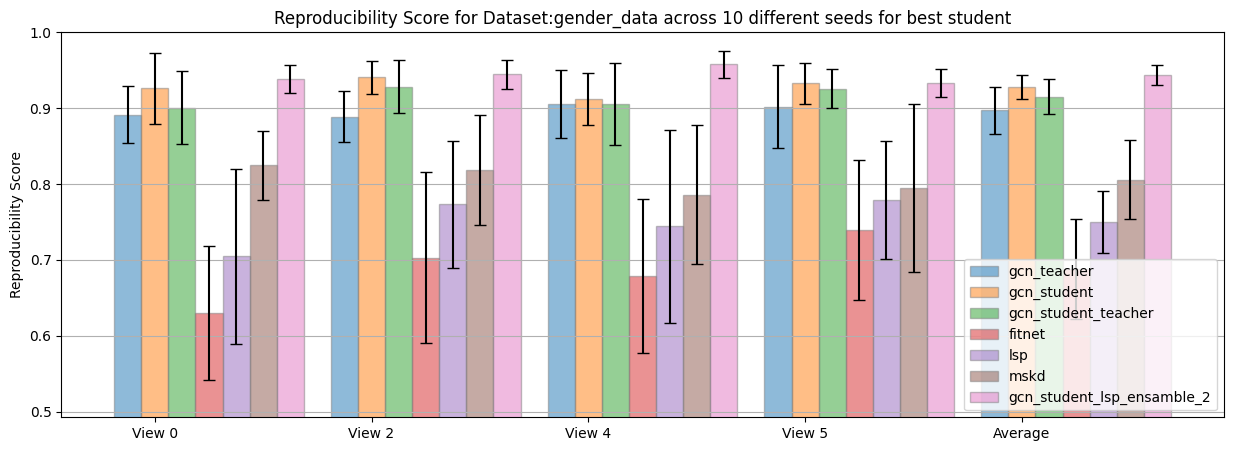

<Figure size 1500x500 with 0 Axes>

In [17]:
plot_bar_chart_reproducibility_mulitple_runs_student_specific(
    dataset="gender_data", 
    views=[0, 2, 4, 5], 
    models=[  
        "gcn", 
        "gcn_student",
        "gcn_student_teacher",
        "fitnet", 
        "lsp", 
        "mskd",
        "gcn_student_lsp_ensamble_2", 
    ], 
    CV=["3Fold", "5Fold", "10Fold"], 
    runs=[i for i in range(10)], 
    students=[0,0,1,1], 
    model_args= [
        gcn_args,
        gcn_student_args,
        gcn_student_args, 
        fitnet_student_args, 
        lsp_student_args, 
        mskd_student_args,
        gcn_student_ensamble_5_args,
    ], 
    save_fig=False)

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


____________________________________________________
View: 0 Metric: acc


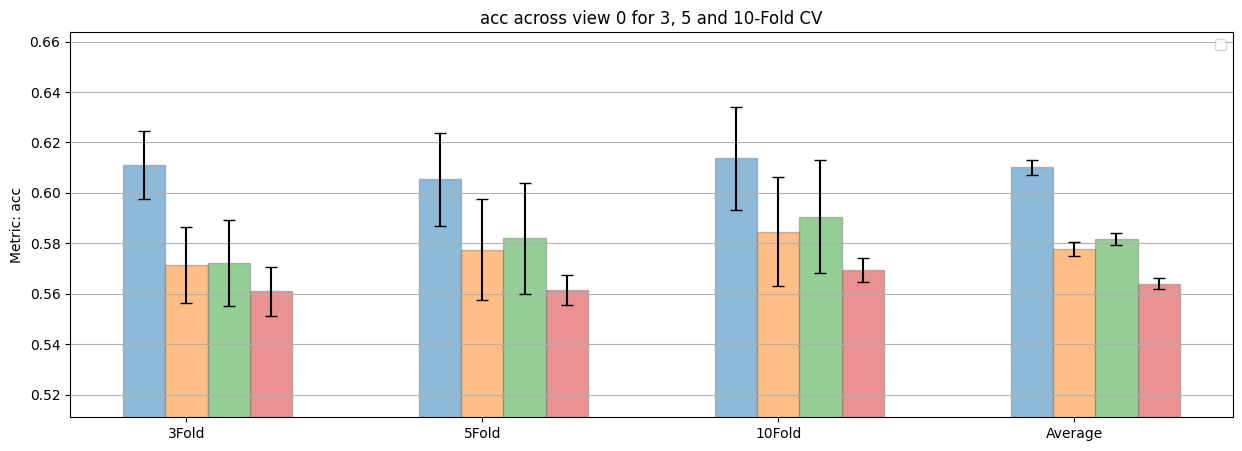

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


____________________________________________________
View: 2 Metric: acc


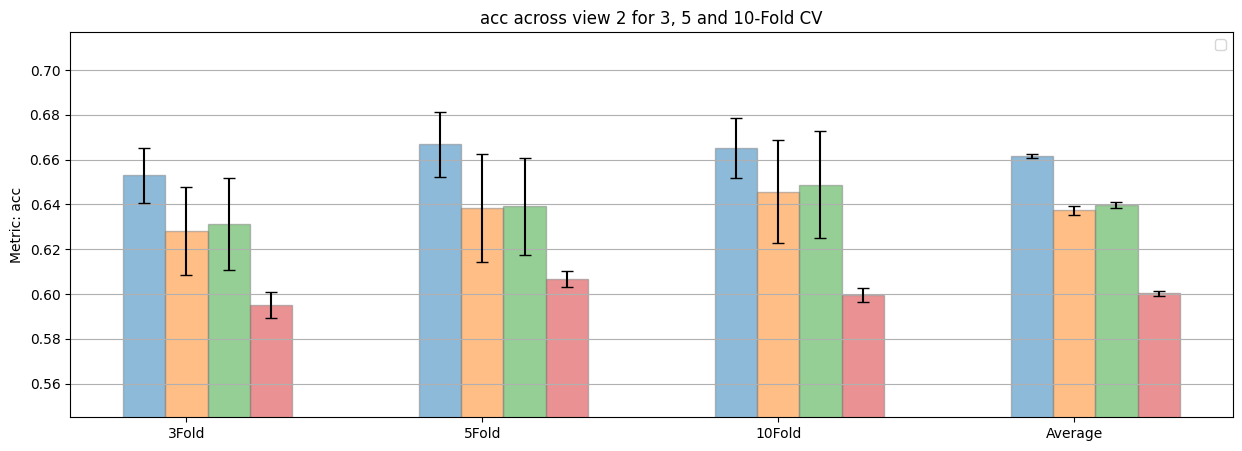

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


____________________________________________________
View: 4 Metric: acc


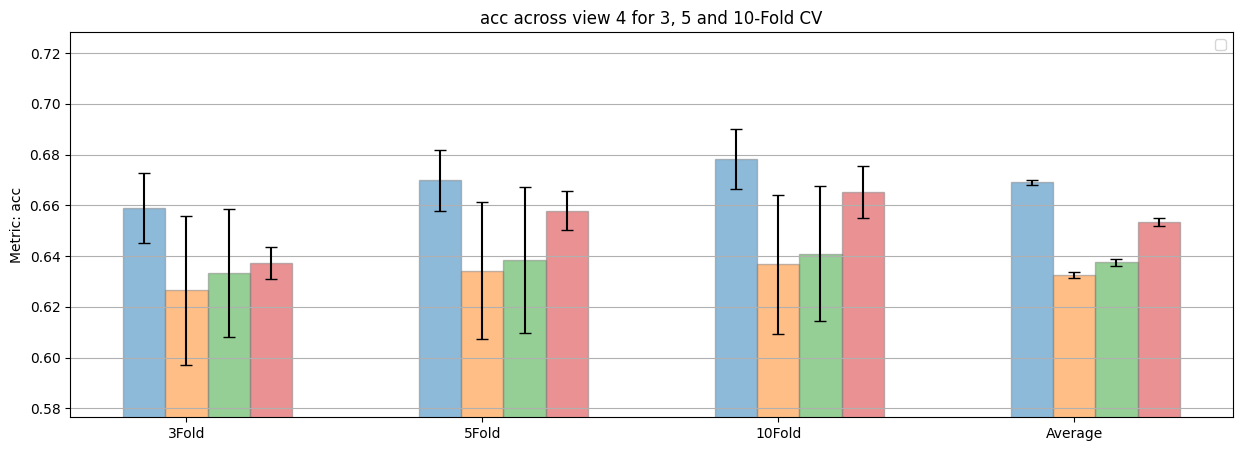

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


____________________________________________________
View: 5 Metric: acc


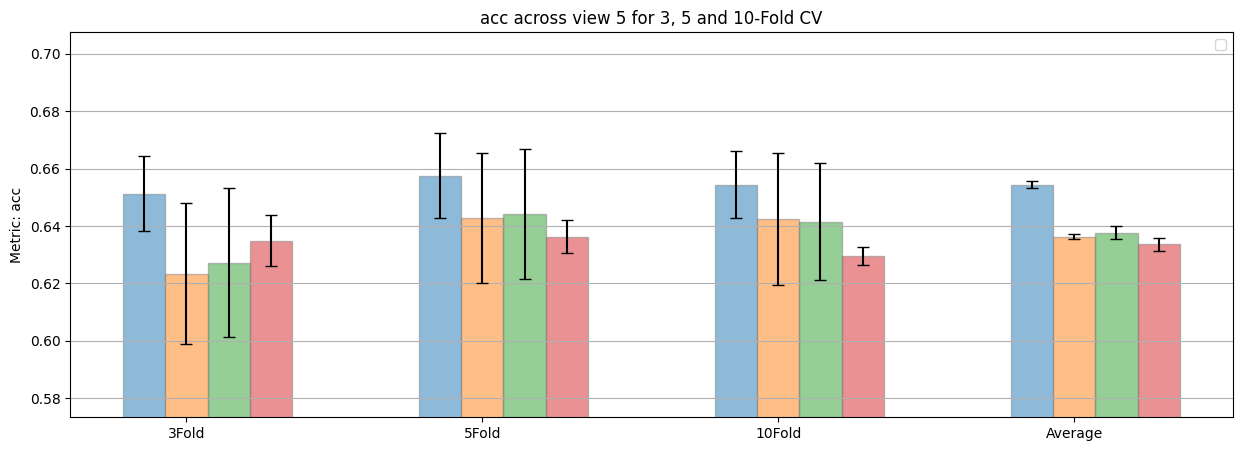

<Figure size 1500x500 with 0 Axes>

In [18]:
from models.model_config import *

views=[0, 2, 4, 5]
CV=["3Fold", "5Fold", "10Fold"]
model = "gcn_student_lsp_ensamble_2"
runs = [i for i in range(10)]
dataset = "gender_data"
dataset_split="val"
analysis_type="model_assessment"
metrics = ["acc"]
model_args= gcn_student_lsp_ensamble_2_args
best_student = [0,0,1,1]

for best_student_i, view in enumerate(views):

    models = ["gcn", "gcn_student", "gcn_student_teacher"]
    mean_all_runs = []
    for run in [i for i in range(10)]:
        view_data_mean, _ = view_metric_analysis(models=models, 
                                                 CV=CV, view=view, 
                                                 run=run, 
                                                 metric="acc", 
                                                 dataset=dataset, 
                                                 dataset_split=dataset_split, 
                                                 analysis_type=analysis_type,
                                                 model_args=[gcn_args, gcn_student_args, gcn_student_args])
        mean_all_runs.append(view_data_mean)

    mean_all_std = np.std(mean_all_runs, axis=0).squeeze()
    mean_all_runs = np.mean(mean_all_runs, axis=0).squeeze()

    index_student = best_student[best_student_i]

    mean, std = get_student_model_metric(dataset, model, CV, runs, analysis_type, dataset_split, view, model_args)
    mean = mean[index_student]
    std = std[index_student]
    
    for i, metric in enumerate(metrics):
        print("____________________________________________________")
        print(f"View: {view} Metric: {metric}")        
        
        mean_df = np.array(mean)[:,i]
        mean_df = mean_df[np.newaxis, :]
        
        std_df = np.array(std)[:,i]
        std_df = std_df[np.newaxis, :]
        
        final_mean_df = np.r_[mean_all_runs, mean_df]
        final_var_df = np.r_[mean_all_std, std_df]

        barWidth = 1/7
        
        #GET MEAN AND STD ACROSS MEAN OF RUNS

        mean_all_runs = np.c_[ final_mean_df, np.mean(final_mean_df, axis=1)]     
        mean_all_std = np.c_[ final_var_df, np.std(final_var_df, axis=1)]  
        
        X = np.arange(len(CV)+1)
        sep = 0.00
        for j, view_d in enumerate(mean_all_runs):
            plt.bar(X + sep, view_d, yerr=mean_all_std[j], capsize=4, width = barWidth, edgecolor ='grey', alpha=0.5)
            sep += barWidth
        
        max_y_lim = np.amax(mean_all_runs) + 0.05
        min_y_lim = np.amin(mean_all_runs) - 0.05
        plt.ylim(min_y_lim, max_y_lim)
        
        #title = f"Dataset:{dataset}, Metric:{metric}, View:{view}, Across: {len(runs)} seeds with fixed init"
        title = f"{metric} across view {view} for 3, 5 and 10-Fold CV"
        
        plt.ylabel(f"Metric: {metric}")
        x_ticks = [i for i in CV]+ ["Average"]
        
        plt.xticks([r + barWidth for r in range(len(CV)+1)], x_ticks)
        plt.title(title)
        plt.grid(axis = 'y')
        plt.legend()
        plt.show()
        plt.clf()   

In [19]:
from models.model_config import *

analysis_type="model_assessment"
dataset_split="val"

for view in [0,2,4,5]:
    print(get_best_student_ensamble(
        model="gcn_student_lsp_ensamble_3", 
        view=view, 
        CV=CV,
        runs=[i for i in range(10)], 
        analysis_type=analysis_type,
        dataset_split=dataset_split,
        model_args=gcn_student_lsp_ensamble_3_args
    )
)

([0.9690277777777778, 9.261188271604957e-05, 1], [0.9683333333333332, 5.2777777777777404e-05, 2], [0.9683333333333332, 5.2777777777777404e-05, 2])
([0.9319444444444445, 0.00019753086419753112, 2], [0.9319444444444445, 0.00019753086419753112, 2], [0.8966666666666667, 0.000316820987654321, 1])
([0.9666666666666666, 7.407407407407434e-05, 2], [0.9666666666666666, 7.407407407407434e-05, 2], [0.9666666666666666, 7.407407407407434e-05, 2])
([0.956111111111111, 0.00020339506172839533, 0], [0.9216666666666666, 8.263888888888885e-05, 1], [0.9216666666666666, 8.263888888888885e-05, 1])


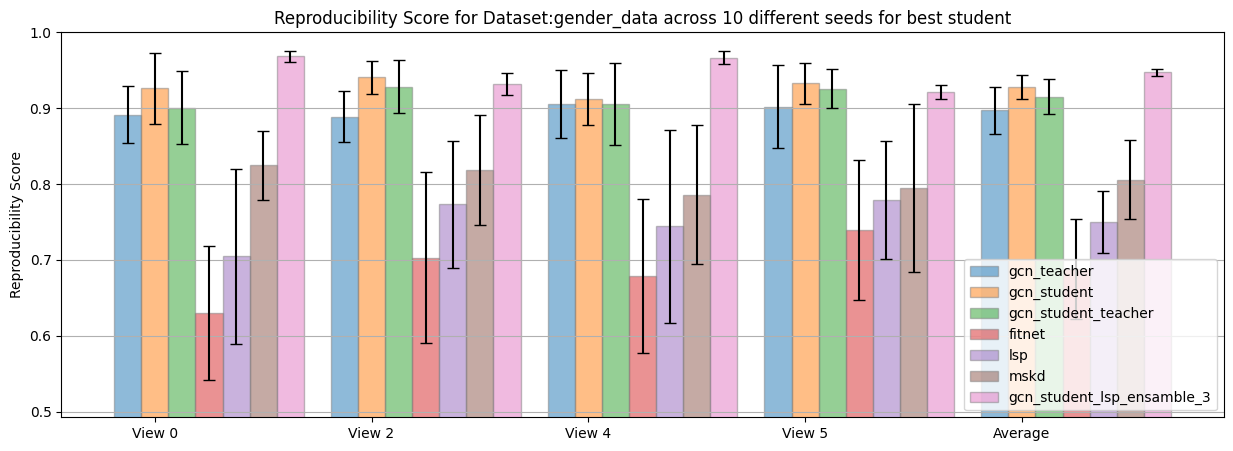

<Figure size 1500x500 with 0 Axes>

In [20]:
plot_bar_chart_reproducibility_mulitple_runs_student_specific(
    dataset="gender_data", 
    views=[0, 2, 4, 5], 
    models=[
        "gcn", 
        "gcn_student",
        "gcn_student_teacher",
        "fitnet", 
        "lsp", 
        "mskd",
        "gcn_student_lsp_ensamble_3", 
    ], 
    CV=["3Fold", "5Fold", "10Fold"], 
    runs=[i for i in range(10)], 
    students=[2,2,2,1], 
    model_args= [
        gcn_args,
        gcn_student_args,
        gcn_student_args, 
        fitnet_student_args, 
        lsp_student_args, 
        mskd_student_args,
        gcn_student_lsp_ensamble_3_args,
    ], 
    save_fig=False)

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


____________________________________________________
View: 0 Metric: acc


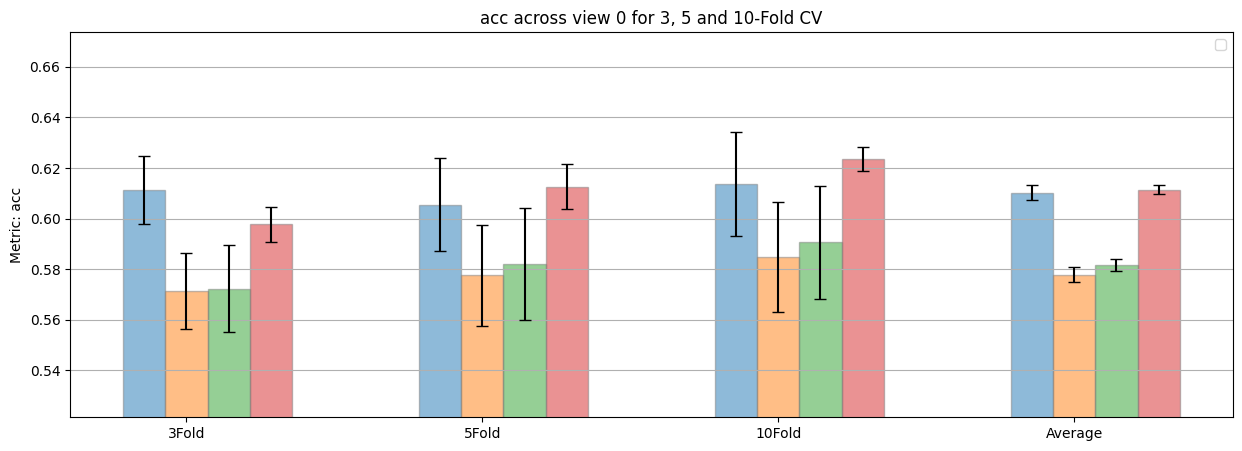

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


____________________________________________________
View: 2 Metric: acc


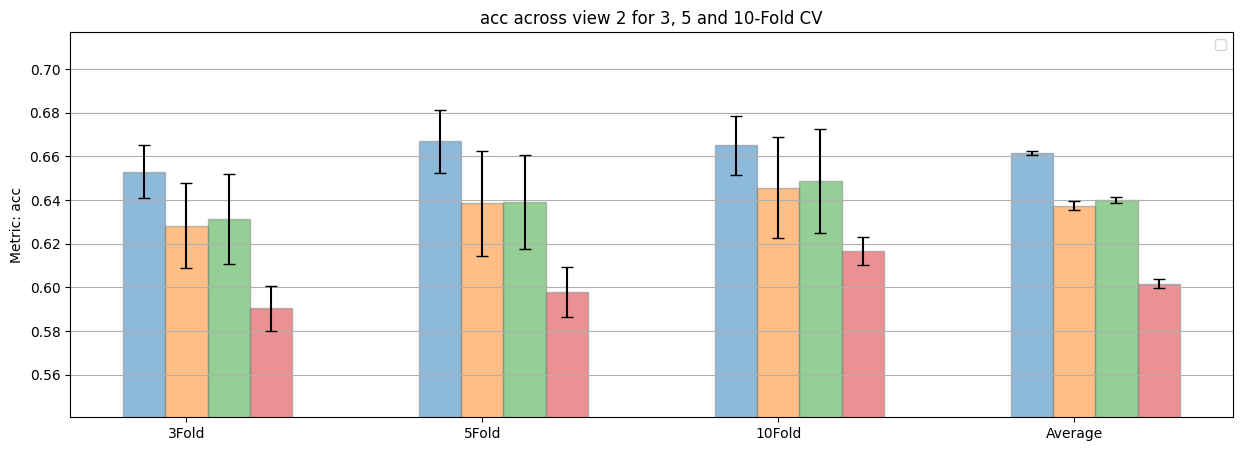

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


____________________________________________________
View: 4 Metric: acc


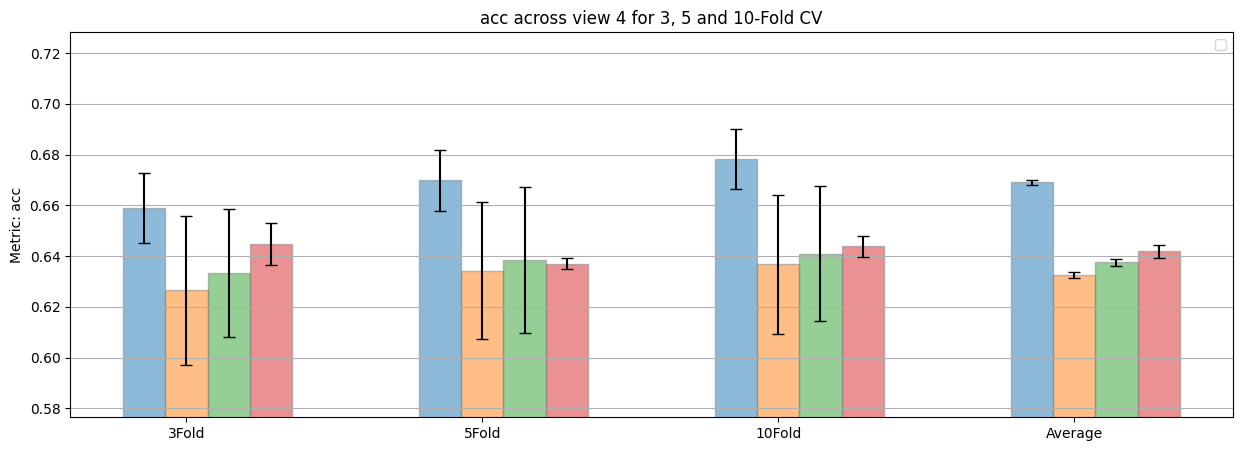

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


____________________________________________________
View: 5 Metric: acc


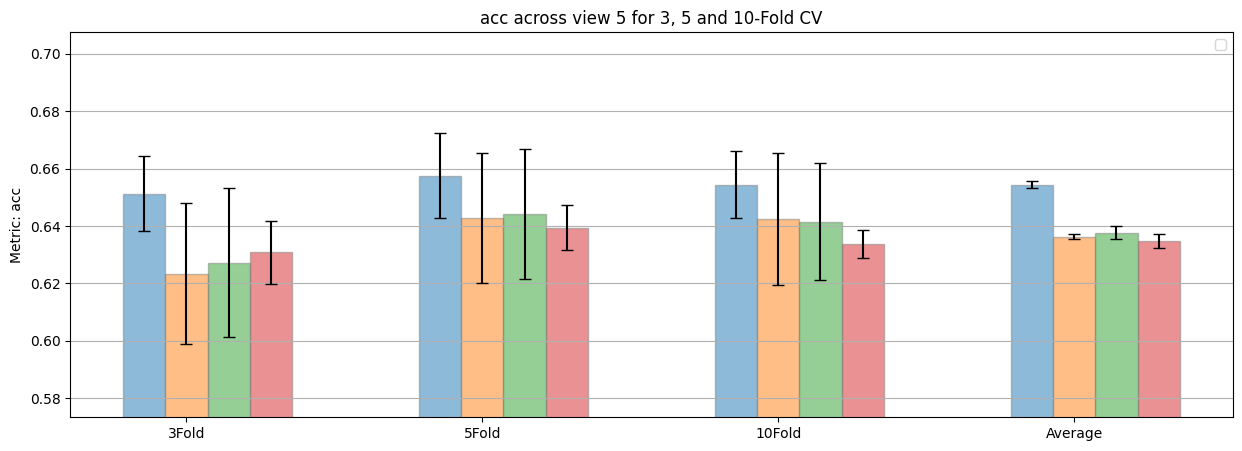

<Figure size 1500x500 with 0 Axes>

In [21]:
from models.model_config import *

views=[0, 2, 4, 5]
CV=["3Fold", "5Fold", "10Fold"]
model = "gcn_student_lsp_ensamble_3"
runs = [i for i in range(10)]
dataset = "gender_data"
dataset_split="val"
analysis_type="model_assessment"
metrics = ["acc"]
model_args= gcn_student_lsp_ensamble_3_args
best_student = [2,2,2,1]

for best_student_i, view in enumerate(views):

    models = ["gcn", "gcn_student", "gcn_student_teacher"]
    mean_all_runs = []
    for run in [i for i in range(10)]:
        view_data_mean, _ = view_metric_analysis(models=models, 
                                                 CV=CV, view=view, 
                                                 run=run, 
                                                 metric="acc", 
                                                 dataset=dataset, 
                                                 dataset_split=dataset_split, 
                                                 analysis_type=analysis_type,
                                                 model_args=[gcn_args, gcn_student_args, gcn_student_args])
        mean_all_runs.append(view_data_mean)

    mean_all_std = np.std(mean_all_runs, axis=0).squeeze()
    mean_all_runs = np.mean(mean_all_runs, axis=0).squeeze()

    index_student = best_student[best_student_i]

    mean, std = get_student_model_metric(dataset, model, CV, runs, analysis_type, dataset_split, view, model_args)
    mean = mean[index_student]
    std = std[index_student]
    
    for i, metric in enumerate(metrics):
        print("____________________________________________________")
        print(f"View: {view} Metric: {metric}")        
        
        mean_df = np.array(mean)[:,i]
        mean_df = mean_df[np.newaxis, :]
        
        std_df = np.array(std)[:,i]
        std_df = std_df[np.newaxis, :]
        
        final_mean_df = np.r_[mean_all_runs, mean_df]
        final_var_df = np.r_[mean_all_std, std_df]

        barWidth = 1/7
        
        #GET MEAN AND STD ACROSS MEAN OF RUNS

        mean_all_runs = np.c_[ final_mean_df, np.mean(final_mean_df, axis=1)]     
        mean_all_std = np.c_[ final_var_df, np.std(final_var_df, axis=1)]  
        
        X = np.arange(len(CV)+1)
        sep = 0.00
        for j, view_d in enumerate(mean_all_runs):
            plt.bar(X + sep, view_d, yerr=mean_all_std[j], capsize=4, width = barWidth, edgecolor ='grey', alpha=0.5)
            sep += barWidth
        
        max_y_lim = np.amax(mean_all_runs) + 0.05
        min_y_lim = np.amin(mean_all_runs) - 0.05
        plt.ylim(min_y_lim, max_y_lim)
        
        #title = f"Dataset:{dataset}, Metric:{metric}, View:{view}, Across: {len(runs)} seeds with fixed init"
        title = f"{metric} across view {view} for 3, 5 and 10-Fold CV"
        
        plt.ylabel(f"Metric: {metric}")
        x_ticks = [i for i in CV]+ ["Average"]
        
        plt.xticks([r + barWidth for r in range(len(CV)+1)], x_ticks)
        plt.title(title)
        plt.grid(axis = 'y')
        plt.legend()
        plt.show()
        plt.clf()   

In [22]:
from models.model_config import *

analysis_type="model_assessment"
dataset_split="val"

for view in [0,2,4,5]:
    print(get_best_student_ensamble(
        model="gcn_student_lsp_ensamble_4", 
        view=view, 
        CV=CV,
        runs=[i for i in range(10)], 
        analysis_type=analysis_type,
        dataset_split=dataset_split,
        model_args=gcn_student_lsp_ensamble_4_args
    )
)

([0.96, 0.0003675925925925923, 2], [0.96, 0.0003675925925925923, 2], [0.96, 0.0003675925925925923, 2])
([0.968888888888889, 5.949074074074056e-05, 1], [0.968888888888889, 5.949074074074056e-05, 1], [0.968888888888889, 5.949074074074056e-05, 1])
([0.9649999999999999, 0.00012222222222222262, 2], [0.9649999999999999, 0.00012222222222222262, 2], [0.9649999999999999, 0.00012222222222222262, 2])
([0.9690277777777778, 0.00019446373456790262, 1], [0.9690277777777778, 0.00019446373456790262, 1], [0.9690277777777778, 0.00019446373456790262, 1])


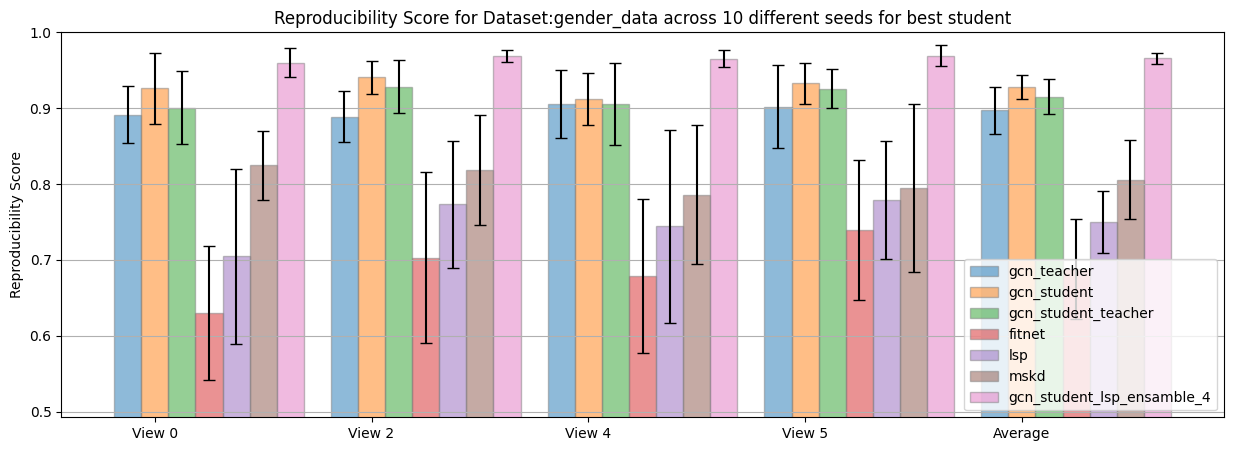

<Figure size 1500x500 with 0 Axes>

In [23]:
plot_bar_chart_reproducibility_mulitple_runs_student_specific(
    dataset="gender_data", 
    views=[0, 2, 4, 5], 
    models=[  
        "gcn", 
        "gcn_student",
        "gcn_student_teacher",
        "fitnet", 
        "lsp", 
        "mskd",
        "gcn_student_lsp_ensamble_4", 
    ], 
    CV=["3Fold", "5Fold", "10Fold"], 
    runs=[i for i in range(10)], 
    students=[2,1,2,1], 
    model_args= [
        gcn_args,
        gcn_student_args,
        gcn_student_args, 
        fitnet_student_args, 
        lsp_student_args, 
        mskd_student_args,
        gcn_student_lsp_ensamble_4_args,
    ], 
    save_fig=False)

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


____________________________________________________
View: 0 Metric: acc


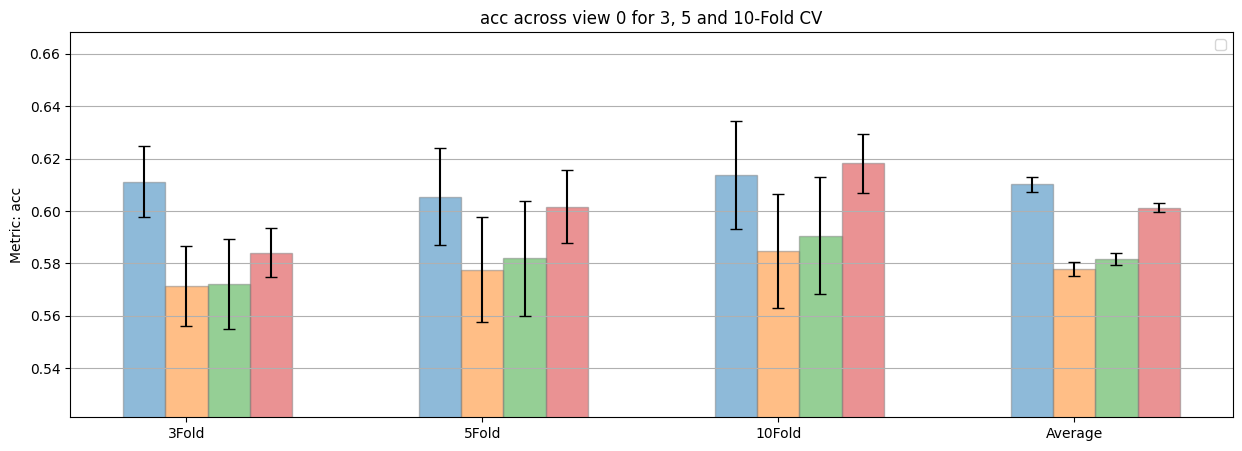

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


____________________________________________________
View: 2 Metric: acc


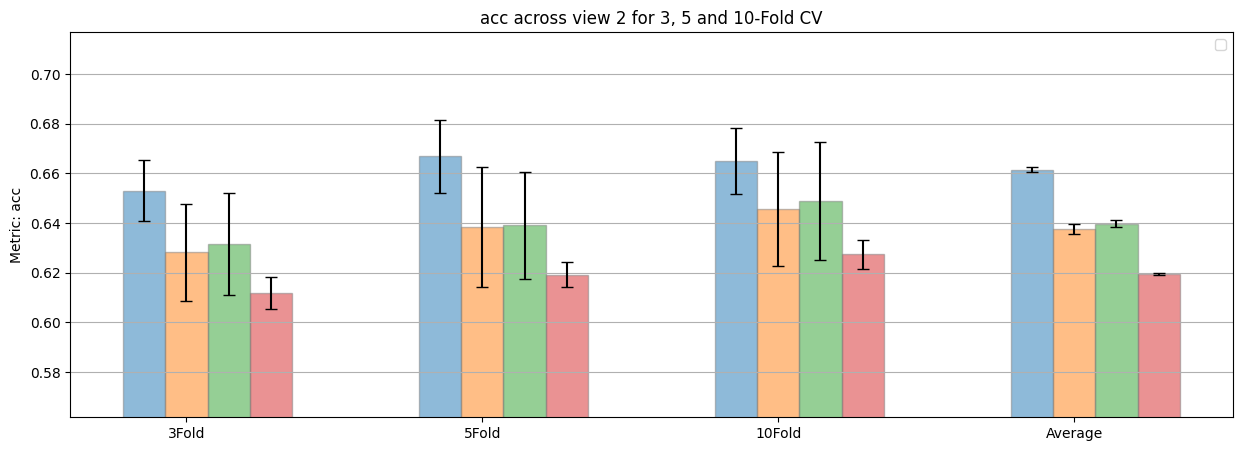

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


____________________________________________________
View: 4 Metric: acc


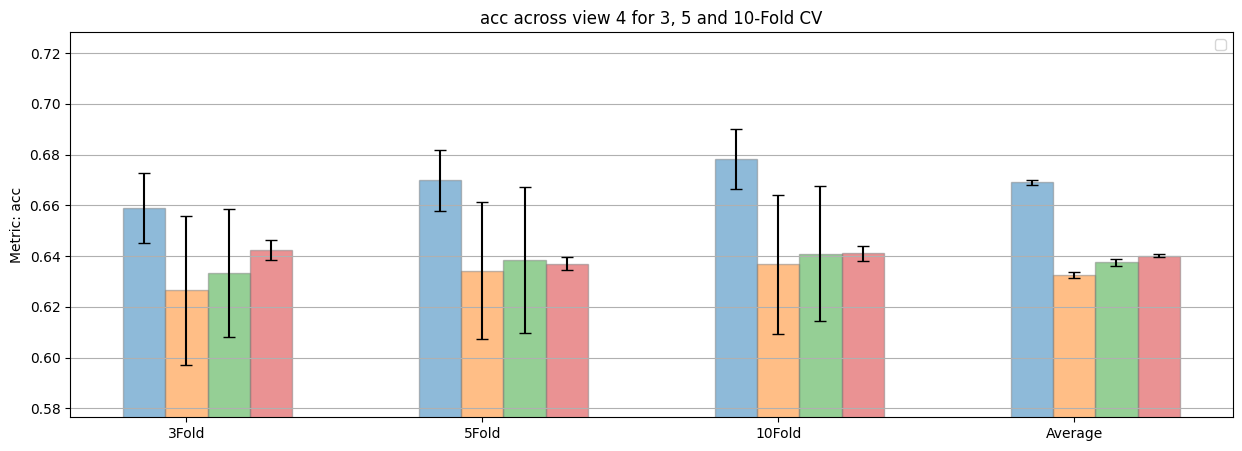

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


____________________________________________________
View: 5 Metric: acc


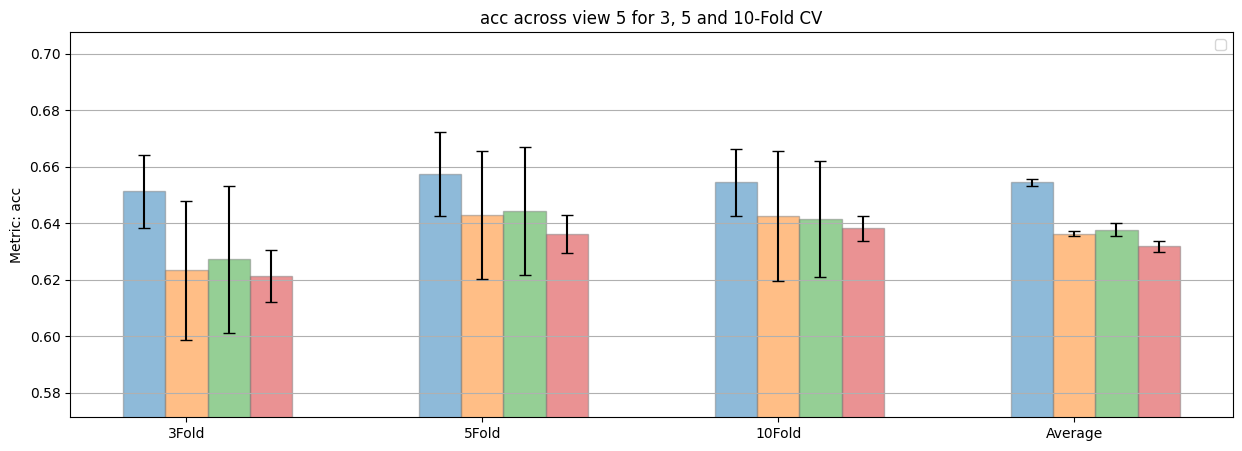

<Figure size 1500x500 with 0 Axes>

In [24]:
from models.model_config import *

views=[0, 2, 4, 5]
CV=["3Fold", "5Fold", "10Fold"]
model = "gcn_student_lsp_ensamble_4"
runs = [i for i in range(10)]
dataset = "gender_data"
dataset_split="val"
analysis_type="model_assessment"
metrics = ["acc"]
model_args= gcn_student_lsp_ensamble_4_args
best_student = [2,1,2,1]

for best_student_i, view in enumerate(views):

    models = ["gcn", "gcn_student", "gcn_student_teacher"]
    mean_all_runs = []
    for run in [i for i in range(10)]:
        view_data_mean, _ = view_metric_analysis(models=models, 
                                                 CV=CV, view=view, 
                                                 run=run, 
                                                 metric="acc", 
                                                 dataset=dataset, 
                                                 dataset_split=dataset_split, 
                                                 analysis_type=analysis_type,
                                                 model_args=[gcn_args, gcn_student_args, gcn_student_args])
        mean_all_runs.append(view_data_mean)

    mean_all_std = np.std(mean_all_runs, axis=0).squeeze()
    mean_all_runs = np.mean(mean_all_runs, axis=0).squeeze()

    index_student = best_student[best_student_i]

    mean, std = get_student_model_metric(dataset, model, CV, runs, analysis_type, dataset_split, view, model_args)
    mean = mean[index_student]
    std = std[index_student]
    
    for i, metric in enumerate(metrics):
        print("____________________________________________________")
        print(f"View: {view} Metric: {metric}")        
        
        mean_df = np.array(mean)[:,i]
        mean_df = mean_df[np.newaxis, :]
        
        std_df = np.array(std)[:,i]
        std_df = std_df[np.newaxis, :]
        
        final_mean_df = np.r_[mean_all_runs, mean_df]
        final_var_df = np.r_[mean_all_std, std_df]

        barWidth = 1/7
        
        #GET MEAN AND STD ACROSS MEAN OF RUNS

        mean_all_runs = np.c_[ final_mean_df, np.mean(final_mean_df, axis=1)]     
        mean_all_std = np.c_[ final_var_df, np.std(final_var_df, axis=1)]  
        
        X = np.arange(len(CV)+1)
        sep = 0.00
        for j, view_d in enumerate(mean_all_runs):
            plt.bar(X + sep, view_d, yerr=mean_all_std[j], capsize=4, width = barWidth, edgecolor ='grey', alpha=0.5)
            sep += barWidth
        
        max_y_lim = np.amax(mean_all_runs) + 0.05
        min_y_lim = np.amin(mean_all_runs) - 0.05
        plt.ylim(min_y_lim, max_y_lim)
        
        #title = f"Dataset:{dataset}, Metric:{metric}, View:{view}, Across: {len(runs)} seeds with fixed init"
        title = f"{metric} across view {view} for 3, 5 and 10-Fold CV"
        
        plt.ylabel(f"Metric: {metric}")
        x_ticks = [i for i in CV]+ ["Average"]
        
        plt.xticks([r + barWidth for r in range(len(CV)+1)], x_ticks)
        plt.title(title)
        plt.grid(axis = 'y')
        plt.legend()
        plt.show()
        plt.clf()   

In [25]:
from models.model_config import *

analysis_type="model_assessment"
dataset_split="val"

for view in [0,2,4,5]:
    print(get_best_student_ensamble(
        model="gcn_student_lsp_ensamble_5", 
        view=view, 
        CV=CV,
        runs=[i for i in range(10)], 
        analysis_type=analysis_type,
        dataset_split=dataset_split,
        model_args=gcn_student_lsp_ensamble_5_args
    )
)

([0.9638888888888889, 0.0001774691358024689, 0], [0.9580555555555555, 0.0004092592592592587, 2], [0.9245833333333333, 0.00032910879629629544, 4])
([0.9783333333333333, 7.222222222222246e-05, 1], [0.9783333333333333, 7.222222222222246e-05, 1], [0.9409722222222221, 0.0002798032407407396, 4])
([0.9772222222222222, 8.148148148148165e-05, 2], [0.9772222222222222, 8.148148148148165e-05, 2], [0.9772222222222222, 8.148148148148165e-05, 2])
([0.9554166666666667, 0.00037633101851851695, 0], [0.9337500000000001, 0.00037463348765431935, 1], [0.9337500000000001, 0.00037463348765431935, 1])


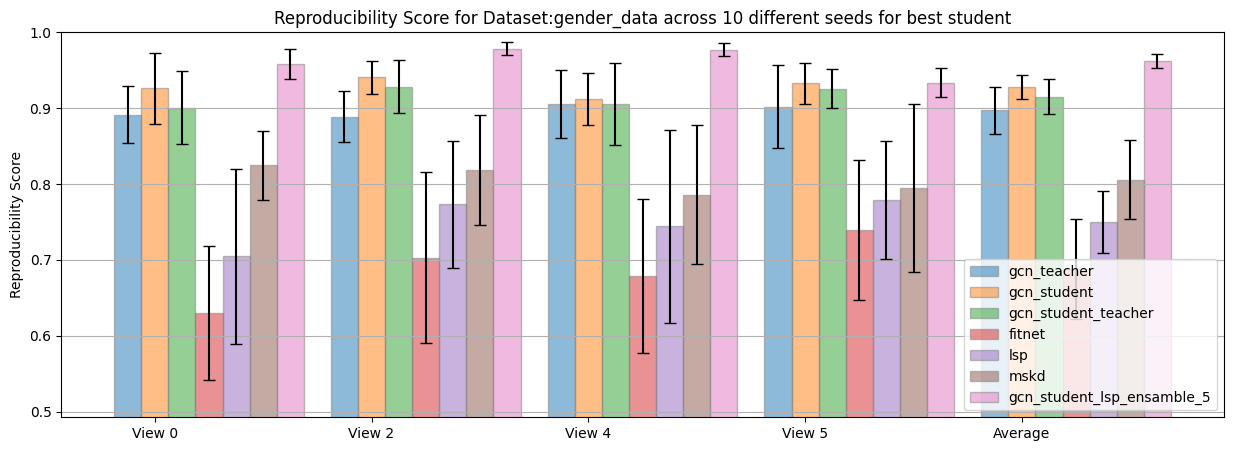

<Figure size 1500x500 with 0 Axes>

In [26]:
plot_bar_chart_reproducibility_mulitple_runs_student_specific(
    dataset="gender_data", 
    views=[0, 2, 4, 5], 
    models=[  
        "gcn", 
        "gcn_student",
        "gcn_student_teacher",
        "fitnet", 
        "lsp", 
        "mskd",
        "gcn_student_lsp_ensamble_5", 
    ], 
    CV=["3Fold", "5Fold", "10Fold"], 
    runs=[i for i in range(10)], 
    students=[2,1,2,1], 
    model_args= [
        gcn_args,
        gcn_student_args,
        gcn_student_args, 
        fitnet_student_args, 
        lsp_student_args, 
        mskd_student_args,
        gcn_student_lsp_ensamble_5_args,
    ], 
    save_fig=False)

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


____________________________________________________
View: 0 Metric: acc


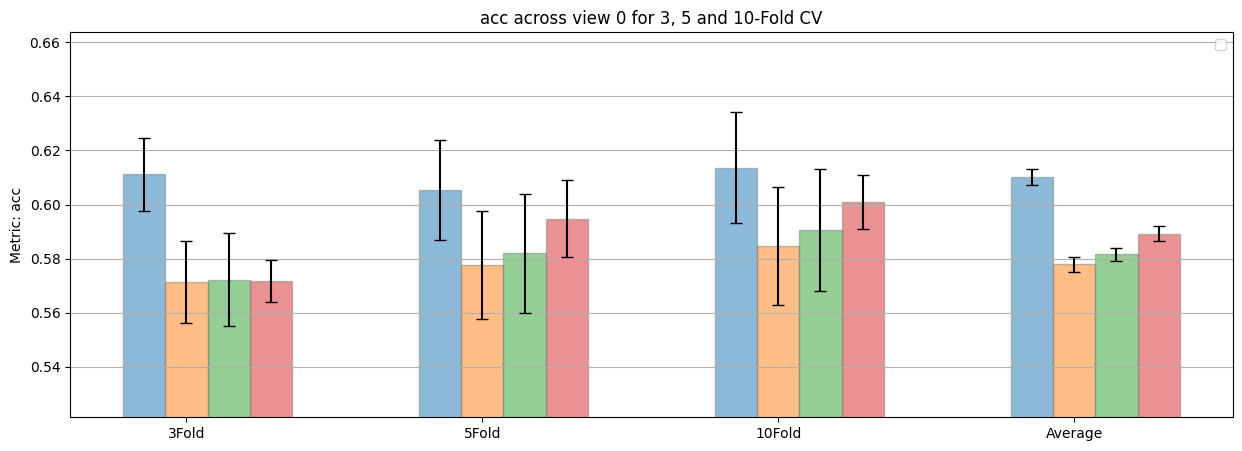

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


____________________________________________________
View: 2 Metric: acc


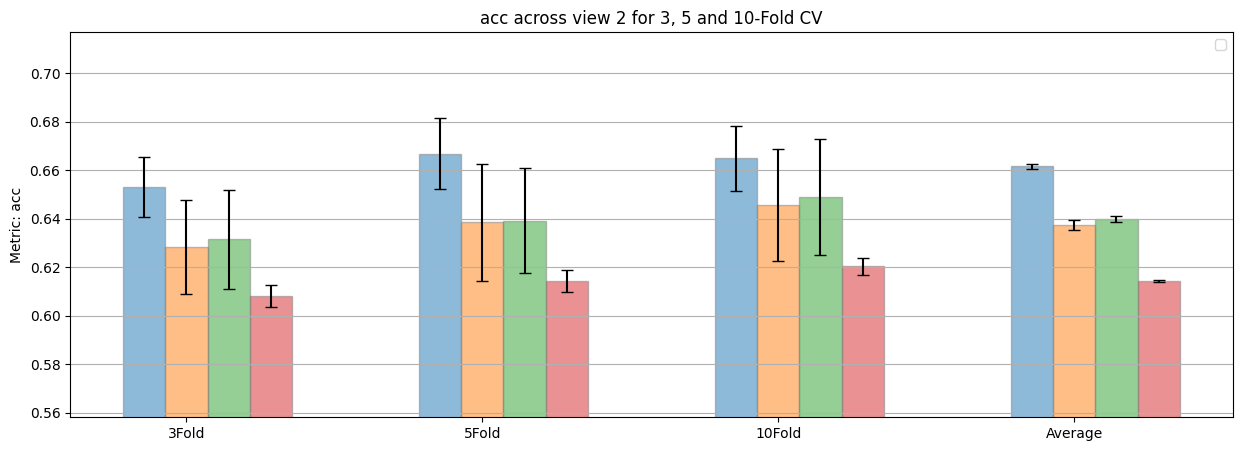

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


____________________________________________________
View: 4 Metric: acc


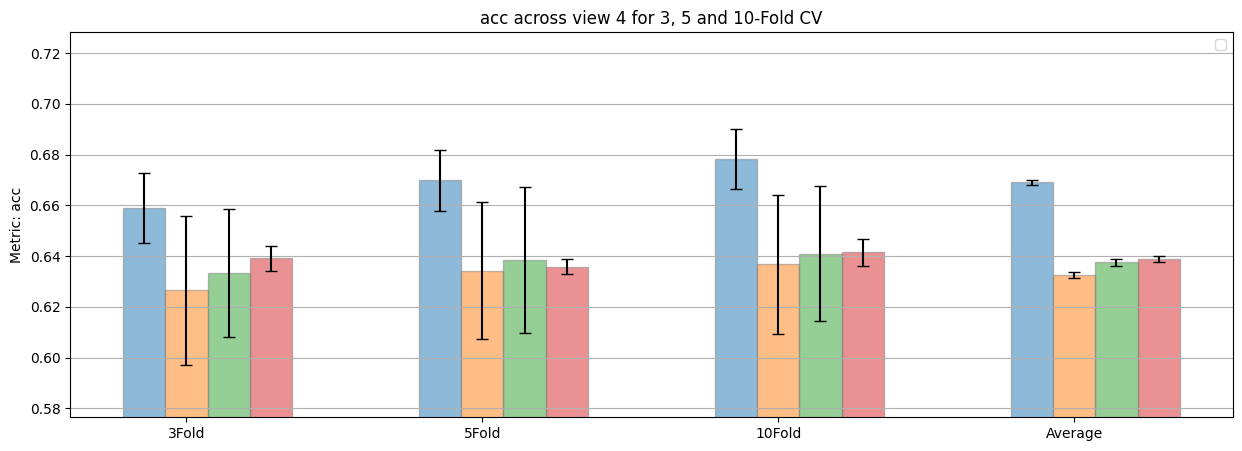

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


____________________________________________________
View: 5 Metric: acc


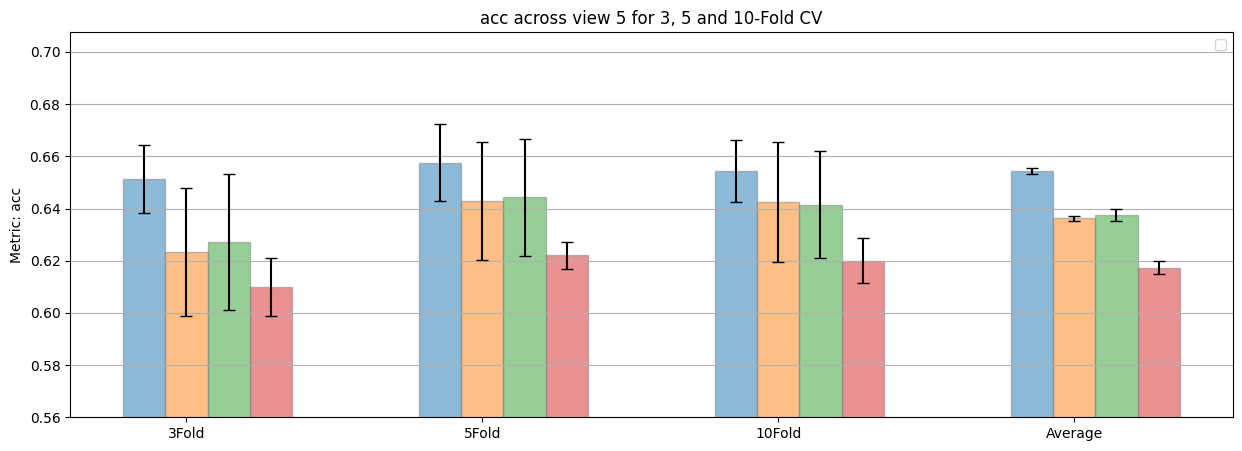

<Figure size 1500x500 with 0 Axes>

In [27]:
from models.model_config import *

views=[0, 2, 4, 5]
CV=["3Fold", "5Fold", "10Fold"]
model = "gcn_student_lsp_ensamble_5"
runs = [i for i in range(10)]
dataset = "gender_data"
dataset_split="val"
analysis_type="model_assessment"
metrics = ["acc"]
model_args= gcn_student_lsp_ensamble_5_args
best_student = [2,1,2,1]

for best_student_i, view in enumerate(views):

    models = ["gcn", "gcn_student", "gcn_student_teacher"]
    mean_all_runs = []
    for run in [i for i in range(10)]:
        view_data_mean, _ = view_metric_analysis(models=models, 
                                                 CV=CV, view=view, 
                                                 run=run, 
                                                 metric="acc", 
                                                 dataset=dataset, 
                                                 dataset_split=dataset_split, 
                                                 analysis_type=analysis_type,
                                                 model_args=[gcn_args, gcn_student_args, gcn_student_args])
        mean_all_runs.append(view_data_mean)

    mean_all_std = np.std(mean_all_runs, axis=0).squeeze()
    mean_all_runs = np.mean(mean_all_runs, axis=0).squeeze()

    index_student = best_student[best_student_i]

    mean, std = get_student_model_metric(dataset, model, CV, runs, analysis_type, dataset_split, view, model_args)
    mean = mean[index_student]
    std = std[index_student]
    
    for i, metric in enumerate(metrics):
        print("____________________________________________________")
        print(f"View: {view} Metric: {metric}")        
        
        mean_df = np.array(mean)[:,i]
        mean_df = mean_df[np.newaxis, :]
        
        std_df = np.array(std)[:,i]
        std_df = std_df[np.newaxis, :]
        
        final_mean_df = np.r_[mean_all_runs, mean_df]
        final_var_df = np.r_[mean_all_std, std_df]

        barWidth = 1/7
        
        #GET MEAN AND STD ACROSS MEAN OF RUNS

        mean_all_runs = np.c_[ final_mean_df, np.mean(final_mean_df, axis=1)]     
        mean_all_std = np.c_[ final_var_df, np.std(final_var_df, axis=1)]  
        
        X = np.arange(len(CV)+1)
        sep = 0.00
        for j, view_d in enumerate(mean_all_runs):
            plt.bar(X + sep, view_d, yerr=mean_all_std[j], capsize=4, width = barWidth, edgecolor ='grey', alpha=0.5)
            sep += barWidth
        
        max_y_lim = np.amax(mean_all_runs) + 0.05
        min_y_lim = np.amin(mean_all_runs) - 0.05
        plt.ylim(min_y_lim, max_y_lim)
        
        #title = f"Dataset:{dataset}, Metric:{metric}, View:{view}, Across: {len(runs)} seeds with fixed init"
        title = f"{metric} across view {view} for 3, 5 and 10-Fold CV"
        
        plt.ylabel(f"Metric: {metric}")
        x_ticks = [i for i in CV]+ ["Average"]
        
        plt.xticks([r + barWidth for r in range(len(CV)+1)], x_ticks)
        plt.title(title)
        plt.grid(axis = 'y')
        plt.legend()
        plt.show()
        plt.clf()   

# COMPARISON BETWEEN LSP AND LOGITS 

In [32]:
from models.model_config import *

analysis_type="model_assessment"
dataset_split="val"
models_args=[
    gcn_student_ensamble_2_args,
    gcn_student_ensamble_3_args,
    gcn_student_ensamble_4_args,
    gcn_student_ensamble_5_args,
    gcn_student_lsp_ensamble_2_args,
    gcn_student_lsp_ensamble_3_args,
    gcn_student_lsp_ensamble_4_args,
    gcn_student_lsp_ensamble_5_args
]

all_model_data_mean = []
all_model_data_std = []

for model_arg in models_args:
    
    model_data_mean = []
    model_data_std = []
    
    print(model_arg["model_name"])
    
    for view in [0,2,4,5]:
        
        rep = get_best_student_ensamble(
            model=model_arg["model_name"], 
            view=view, 
            CV=CV,
            runs=[i for i in range(10)], 
            analysis_type=analysis_type,
            dataset_split=dataset_split,
            model_args=model_arg
        )[0]
        model_data_mean.append(rep[0])
        model_data_std.append(rep[1])
    
    all_model_data_mean.append(model_data_mean)
    all_model_data_std.append(model_data_std)

gcn_student_ensamble_2
gcn_student_ensamble_3
gcn_student_ensamble_4
gcn_student_ensamble_5
gcn_student_lsp_ensamble_2
gcn_student_lsp_ensamble_3
gcn_student_lsp_ensamble_4
gcn_student_lsp_ensamble_5


In [108]:
df = pd.DataFrame(all_model_data_mean)

df_transposed = df.T
# Calculate the mean along each column
mean_row = df_transposed.mean()

# Add the mean row to the transposed DataFrame
df_transposed = df_transposed.append(mean_row, ignore_index=True)
print(df_transposed.head())

          0         1         2         3         4         5         6  \
0  0.940556  0.968750  0.972222  0.966806  0.938472  0.969028  0.960000   
1  0.929722  0.932083  0.953056  0.967778  0.944444  0.931944  0.968889   
2  0.943889  0.957778  0.961111  0.975556  0.957917  0.966667  0.965000   
3  0.946111  0.948611  0.955278  0.959722  0.957778  0.956111  0.969028   
4  0.940069  0.951806  0.960417  0.967465  0.949653  0.955937  0.965729   

          7  
0  0.963889  
1  0.978333  
2  0.977222  
3  0.955417  
4  0.968715  


In [109]:
df = pd.DataFrame(np.sqrt(all_model_data_std))

df_transposed_var = df.T
# Calculate the mean along each column
std_row = df_transposed.std()

# Add the mean row to the transposed DataFrame
df_std_transposed = df_transposed_var.append(std_row, ignore_index=True)
df_std_transposed

,0,1,2,3,4,5,6,7
0,0.022229,0.004270,0.017213,0.022209,0.016090,0.009624,0.019173,0.013322
1,0.018934,0.028467,0.022608,0.017222,0.019355,0.014055,0.007713,0.008498
2,0.026074,0.010323,0.011785,0.014530,0.017624,0.008607,0.011055,0.009027
3,0.019011,0.018405,0.011749,0.023741,0.014948,0.014262,0.013945,0.019399
4,0.006293,0.013435,0.007424,0.005611,0.008462,0.014681,0.003682,0.009553


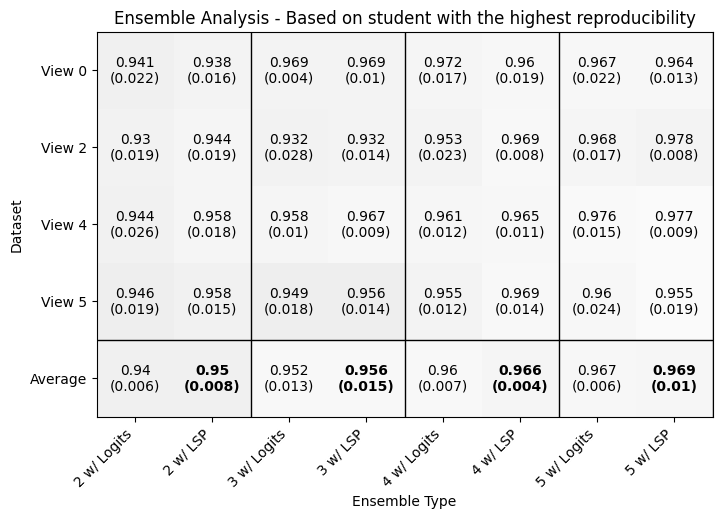

In [156]:
import matplotlib.pyplot as plt
import numpy as np

# Change the order of the DataFrame columns
column_order = [0, 4, 1, 5, 2, 6, 3, 7]
df_ordered = df_transposed.iloc[:, column_order]
df_std_ordered = df_std_transposed.iloc[:, column_order]

# Create a white heatmap with a grayscale colormap
plt.imshow(df_ordered.values, cmap='gray', extent=[-0.5, df_ordered.shape[1] - 0.5, -0.5, df_ordered.shape[0] - 0.5], vmin=0, vmax=1)

# Find the maximum value for each pair of rows and round to 3 significant figures
max_values = []
for i in range(0, df.shape[0], 2):
    pair_max = max(df.iloc[i:i+2]['Values'])
    pair_max_rounded = round(pair_max, 3)
    max_values.append(pair_max_rounded)

# Iterate over the DataFrame and highlight the maximum value for each pair in the "Average" row
for i in range(df_ordered.shape[0]):
    for j in range(df_ordered.shape[1]):
        value = round(df_ordered.values[i, j], 3)  # Round to 3 significant figures
        std = round(df_std_ordered.values[i, j], 3)  # Round standard deviation to 3 significant figures
        if i == 4 and value in max_values:
            plt.text(j, i, f'{value}\n({std})', ha='center', va='center', color='black', weight='bold')
        else:
            plt.text(j, i, f'{value}\n({std})', ha='center', va='center', color='black')

plt.axhline(3.5, color='black', linewidth=1)  # Add a horizontal line on top of the "Average" row

# Add vertical lines spaced 2 cells apart
for j in range(1, df_ordered.shape[1], 2):
    plt.axvline(j + 0.5, color='black', linewidth=1)  # Add a vertical line in the middle of each pair


plt.gca().invert_yaxis()  # Reverse the y-axis

# Add custom labels to the y-axis
labels = ['View 0', 'View 2', 'View 4', 'View 5', 'Average']
plt.yticks(range(df_ordered.shape[0]), labels)

# Add custom labels to the x-axis
x_ticks = ['2 w/ Logits', '2 w/ LSP', '3 w/ Logits', '3 w/ LSP','4 w/ Logits', '4 w/ LSP', '5 w/ Logits', '5 w/ LSP']
plt.xticks(range(df_ordered.shape[1]), x_ticks, rotation=45, ha='right')

# Add title and axis labels
plt.title('Ensemble Analysis - Based on student with the highest reproducibility')
plt.xlabel('Ensemble Type')
plt.ylabel('Dataset')

plt.show()


In [410]:
from models.model_config import *

analysis_type="model_assessment"
dataset_split="val"
models_args=[
    gcn_student_ensamble_2_args,
    gcn_student_ensamble_3_args,
    gcn_student_ensamble_4_args,
    gcn_student_ensamble_5_args,
    gcn_student_lsp_ensamble_2_args,
    gcn_student_lsp_ensamble_3_args,
    gcn_student_lsp_ensamble_4_args,
    gcn_student_lsp_ensamble_5_args
]

all_model_metrics_mean = []
all_model_metrics_var = []
all_model_best_student = []

for model_arg in models_args:
    
    print(model_arg["model_name"])

    model_metrics_mean = []
    model_metrics_var = []
    model_best_student = []

    for view in [0,2,4,5]:
        mean, var, best_students = get_best_student_ensamble_detailed(
            model=model_arg["model_name"], 
            view=view, 
            CV=CV,
            runs=[i for i in range(10)], 
            analysis_type=analysis_type,
            dataset_split=dataset_split,
            model_args=model_arg
        )
        print(best_students)
        model_metrics_mean.append(mean)
        model_metrics_var.append(var)
        model_best_student.append(best_students)

    all_model_metrics_mean.append(model_metrics_mean)
    all_model_metrics_var.append(model_metrics_var)
    all_model_best_student.append(model_best_student)

gcn_student_ensamble_2
[[0.9405555555555555, 0.000494135802469136, 0], [0.9405555555555555, 0.000494135802469136, 0], [0.9156944444444445, 0.0005571180555555544, 1], [0.9405555555555555, 0.000494135802469136, 0], [0.9156944444444445, 0.0005571180555555544, 1]]
[[0.9297222222222221, 0.0003584876543209886, 0], [0.8902777777777778, 0.0001358024691358015, 1], [0.8902777777777778, 0.0001358024691358015, 1], [0.9297222222222221, 0.0003584876543209886, 0], [0.8902777777777778, 0.0001358024691358015, 1]]
[[0.943888888888889, 0.0006798611111111126, 1], [0.943888888888889, 0.0006798611111111126, 1], [0.943888888888889, 0.0006798611111111126, 1], [0.943888888888889, 0.0006798611111111126, 1], [0.943888888888889, 0.0006798611111111126, 1]]
[[0.946111111111111, 0.000361419753086421, 1], [0.946111111111111, 0.000361419753086421, 1], [0.946111111111111, 0.000361419753086421, 1], [0.946111111111111, 0.000361419753086421, 1], [0.946111111111111, 0.000361419753086421, 1]]
gcn_student_ensamble_3
[[0.9687

In [560]:
df_best_student = np.array(all_model_best_student)
df = []
for i in range(4):
    df.append(df_best_student[:, i, :, 0].flatten())
df = pd.DataFrame(np.array(df))
# Calculate the mean of columns
mean_row = df.mean(axis=0)

# Append the mean row to the DataFrame
df = df.append(mean_row, ignore_index=True).T
index_values = ['max rep', 'max acc', 'max f1', 'weighted acc', 'weighted f1'] * (len(df) // 5) + ['max rep', 'max acc', 'max f1', 'weighted acc', 'weighted f1'][:len(df) % 5]

# Assign the new index to the DataFrame
df.index = index_values
df.shape

(40, 5)

In [561]:
index = df_best_student[:,:,:,2]
all_data_accuracy = []
for view_index in range(4):
    view_data = []
    ensamble_indexes = index[:,view_index,:]
    ensamble_data = np.array(all_model_metrics_mean)[:,view_index]
    #number of ensembles 
    for i in range(8):
        view_data.append([ensamble_data[i][int(best_student_index)][0] for best_student_index in ensamble_indexes[i]])
    all_data_accuracy.append(np.array(view_data).flatten())

In [562]:
all_data_var = []
for view_index in range(4):
    view_data = []
    ensamble_indexes = index[:,view_index,:]
    ensamble_data = np.array(all_model_metrics_var)[:,view_index]
    #number of ensembles 
    for i in range(8):
        view_data.append([ensamble_data[i][int(best_student_index)][0] for best_student_index in ensamble_indexes[i]])
    all_data_var.append(np.array(view_data).flatten())

In [563]:
df_acuracy = pd.DataFrame(np.array(all_data_accuracy))
# Calculate the mean of columns
mean_row = df_acuracy.mean(axis=0)

# Append the mean row to the DataFrame
df_acuracy = df_acuracy.append(mean_row, ignore_index=True).T
# Create the list of repeating index values
index_values = ['max rep', 'max acc', 'max f1', 'weighted acc', 'weighted f1'] * (len(df_acuracy) // 5) + ['max rep', 'max acc', 'max f1', 'weighted acc', 'weighted f1'][:len(df_acuracy) % 5]

# Assign the new index to the DataFrame
df_acuracy.index = index_values
df_acuracy.shape

(40, 5)

In [564]:
df_var = pd.DataFrame(np.array(all_data_var))
# Calculate the mean of columns
mean_row = df_var.mean(axis=0)

# Append the mean row to the DataFrame
df_var = df_var.append(mean_row, ignore_index=True).T
# Create the list of repeating index values
index_values = ['max rep', 'max acc', 'max f1', 'weighted acc', 'weighted f1'] * (len(df_var) // 5) + ['max rep', 'max acc', 'max f1', 'weighted acc', 'weighted f1'][:len(df_var) % 5]

# Assign the new index to the DataFrame
df_var.index = index_values
df_var.shape

(40, 5)

In [565]:
df_acuracy = df_acuracy.loc['max rep'].T
df_var = df_var.loc['max rep'].T
df_var = np.sqrt(df_var)

In [566]:
import pandas as pd

# Assuming you have a DataFrame called 'df' with the given data

# Define the new column labels
new_labels = ['2 w/ Logits', '3 w/ Logits', '4 w/ Logits','5 w/ Logits', '2 w/ LSP', '3 w/ LSP', '4 w/ LSP',  '5 w/ LSP']
# Rename the columns using the new labels
df_acuracy.columns = new_labels
df_var.columns = new_labels
# Display the modified DataFrame
df_var

,2 w/ Logits,3 w/ Logits,4 w/ Logits,5 w/ Logits,2 w/ LSP,3 w/ LSP,4 w/ LSP,5 w/ LSP
0,0.005647,0.007414,0.010266,0.005254,0.003565,0.005010,0.009602,0.006157
1,0.002587,0.003368,0.003574,0.007661,0.003084,0.007322,0.004146,0.002374
2,0.006626,0.004166,0.002682,0.005347,0.005716,0.002912,0.002405,0.002883
3,0.004202,0.008354,0.004669,0.004186,0.006139,0.006898,0.003948,0.006130
4,0.005003,0.006194,0.006065,0.005754,0.004811,0.005805,0.005718,0.004728


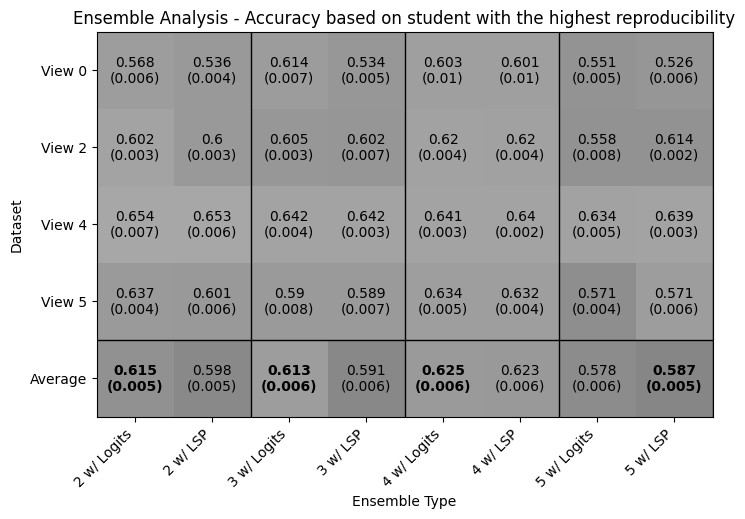

In [567]:
import matplotlib.pyplot as plt
import numpy as np

# Change the order of the DataFrame columns
column_order = [0, 4, 1, 5, 2, 6, 3, 7]
df_ordered = df_acuracy.iloc[:, column_order]
df_std_ordered = df_var.iloc[:, column_order]
# Create a white heatmap with a grayscale colormap
plt.imshow(df_ordered.values, cmap='gray', extent=[-0.5, df_ordered.shape[1] - 0.5, -0.5, df_ordered.shape[0] - 0.5], vmin=0, vmax=1)

# Find the maximum value for each pair of rows and round to 3 significant figures
max_values = []
for i in range(0, df_ordered.T.shape[0], 2):
    print()
    pair_max = max(df_ordered.iloc[4].iloc[i:i+2])
    pair_max_rounded = round(pair_max, 3)
    max_values.append(pair_max_rounded)
    
# Iterate over the DataFrame and highlight the maximum value for each pair in the "Average" row
for i in range(df_ordered.shape[0]):
    for j in range(df_ordered.shape[1]):
        value = round(df_ordered.values[i, j], 3)  # Round to 3 significant figures
        std = round(df_std_ordered.values[i, j], 3)  # Round standard deviation to 3 significant figures
        if i == 4 and value in max_values:
            plt.text(j, i, f'{value}\n({std})', ha='center', va='center', color='black', weight='bold')
        else:
            plt.text(j, i, f'{value}\n({std})', ha='center', va='center', color='black')

plt.axhline(3.5, color='black', linewidth=1)  # Add a horizontal line on top of the "Average" row

# Add vertical lines spaced 2 cells apart
for j in range(1, df_ordered.shape[1], 2):
    plt.axvline(j + 0.5, color='black', linewidth=1)  # Add a vertical line in the middle of each pair


plt.gca().invert_yaxis()  # Reverse the y-axis

# Add custom labels to the y-axis
labels = ['View 0', 'View 2', 'View 4', 'View 5', 'Average']
plt.yticks(range(df_ordered.shape[0]), labels)

# Add custom labels to the x-axis
x_ticks = ['2 w/ Logits', '2 w/ LSP', '3 w/ Logits', '3 w/ LSP','4 w/ Logits', '4 w/ LSP', '5 w/ Logits', '5 w/ LSP']
plt.xticks(range(df_ordered.shape[1]), x_ticks, rotation=45, ha='right')

# Add title and axis labels
plt.title('Ensemble Analysis - Accuracy based on student with the highest reproducibility')
plt.xlabel('Ensemble Type')
plt.ylabel('Dataset')

plt.show()


## HOW TO PICK THE BEST STUDENT 

In [166]:
def get_best_student_ensamble_detailed(model, view, CV, runs, dataset_split, analysis_type, model_args):
    import warnings
    warnings.filterwarnings('ignore')
    
    student_rep = []
    student_var = []

    # get the best reproducibility across all runs 
    for run in runs:

        mean_all_runs = []

        for student in range(model_args["n_students"]):
            view_rep, _ = view_reproducibility_analysis(
                dataset=dataset, 
                models=[model], 
                CV=CV, 
                views=[view], 
                run=run, 
                students=[student], 
                model_args=[model_args]
            )
            mean_all_runs.append(view_rep[0][0])
        #store the reproducibility score for all students for the run 
        student_rep.append(mean_all_runs)
    
    #get the mean and variance for the reproducibility scores for all the students
    student_var = np.var(student_rep, axis=0)
    student_rep = np.mean(student_rep, axis=0)

    #get the metrics of all the student models
    all_student_metrics_mean, all_student_metrics_var = get_student_model_metric_all_folds(
        dataset=dataset, 
        model=model, 
        CV=CV, 
        runs=runs, 
        analysis_type=analysis_type, 
        dataset_split=dataset_split, 
        view=view, 
        model_args=model_args
    )
    
    #get the best model based soley on max reproducibility 
    best_rep_max = 0
    metric = 0
    student_max = -1
    for i, rep in enumerate(student_rep):
        if rep > metric:
            best_rep_max = rep 
            metric = rep
            student_max = i

    #get the best model based on max accuracy
    best_max_acc = 0
    metric = 0
    student_max_acc_index = -1
    for i, rep in enumerate(student_rep):
        student_acc = all_student_metrics_mean[i][0]
        if student_acc > metric:
            metric = student_acc
            best_max_acc = rep
            student_max_acc_index = i

    #get the best model based on max reproducibility and f1 score
    best_max_f1 = 0
    metric = 0
    student_max_f1_index = -1
    for i, rep in enumerate(student_rep):
        student_f1 = all_student_metrics_mean[i][1]
        if student_f1 > metric:
            metric = student_f1
            best_max_f1 = rep
            student_max_f1_index = i

    #get the best model based on max reproducibility and accuracy
    best_rep_acc = 0
    metric = 0
    student_acc_index = -1
    for i, rep in enumerate(student_rep):
        student_acc = all_student_metrics_mean[i][0]
        if (rep+student_acc)/2 > metric:
            metric = (rep+student_acc)/2 
            best_rep_acc = rep
            student_acc_index = i
    
    #get the best model based on max reproducibility and f1 score
    best_rep_f1 = 0
    metric = 0
    student_f1_index = -1
    for i, rep in enumerate(student_rep):
        student_f1 = all_student_metrics_mean[i][1]
        if (rep+student_f1)/2 > metric:
            metric = (rep+student_f1)/2 
            best_rep_f1 = rep
            student_f1_index = i
    
    return all_student_metrics_mean, all_student_metrics_var, [[best_rep_max, student_var[student_max], student_max], [best_max_acc, student_var[student_max_acc_index], student_max_acc_index], [best_max_f1, student_var[student_max_f1_index], student_max_f1_index], [best_rep_acc, student_var[student_acc_index], student_acc_index], [best_rep_f1, student_var[student_f1_index], student_f1_index]]
    

In [168]:
from models.model_config import *

analysis_type="model_assessment"
dataset_split="val"
models_args=[
    gcn_student_lsp_ensamble_2_args,
    gcn_student_lsp_ensamble_3_args,
    gcn_student_lsp_ensamble_4_args,
    gcn_student_lsp_ensamble_5_args
]

all_model_metrics_mean = []
all_model_metrics_var = []
all_model_best_student = []

for model_arg in models_args:
    
    print(model_arg["model_name"])

    model_metrics_mean = []
    model_metrics_var = []
    model_best_student = []

    for view in [0,2,4,5]:
        mean, var, best_students = get_best_student_ensamble_detailed(
            model=model_arg["model_name"], 
            view=view, 
            CV=CV,
            runs=[i for i in range(10)], 
            analysis_type=analysis_type,
            dataset_split=dataset_split,
            model_args=model_arg
        )
        print(best_students)
        model_metrics_mean.append(mean)
        model_metrics_var.append(var)
        model_best_student.append(best_students)

    all_model_metrics_mean.append(model_metrics_mean)
    all_model_metrics_var.append(model_metrics_var)
    all_model_best_student.append(model_best_student)


gcn_student_lsp_ensamble_2
[[0.9384722222222223, 0.00025889274691358056, 1], [0.9383333333333332, 0.0003453703703703699, 0], [0.9384722222222223, 0.00025889274691358056, 1], [0.9383333333333332, 0.0003453703703703699, 0], [0.9384722222222223, 0.00025889274691358056, 1]]
[[0.9444444444444444, 0.00037461419753086217, 0], [0.8927777777777777, 0.0002483796296296277, 1], [0.8927777777777777, 0.0002483796296296277, 1], [0.9444444444444444, 0.00037461419753086217, 0], [0.8927777777777777, 0.0002483796296296277, 1]]
[[0.9579166666666667, 0.00031059027777777855, 1], [0.9579166666666667, 0.00031059027777777855, 1], [0.9579166666666667, 0.00031059027777777855, 1], [0.9579166666666667, 0.00031059027777777855, 1], [0.9579166666666667, 0.00031059027777777855, 1]]
[[0.9577777777777777, 0.0002234567901234572, 0], [0.9330555555555555, 0.0003340277777777791, 1], [0.9330555555555555, 0.0003340277777777791, 1], [0.9330555555555555, 0.0003340277777777791, 1], [0.9330555555555555, 0.0003340277777777791, 1]]

In [190]:
#Model, view, how to pick, [rep, std, index]
df_best_student = np.array(all_model_best_student)

In [360]:
df = []
for i in range(4):
    df.append(df_best_student[:, i, :, 0].flatten())
df = pd.DataFrame(np.array(df))
# Calculate the mean of columns
mean_row = df.mean(axis=0)

# Append the mean row to the DataFrame
df = df.append(mean_row, ignore_index=True).T
index_values = ['max rep', 'max acc', 'max f1', 'weighted acc', 'weighted f1'] * (len(df) // 5) + ['max rep', 'max acc', 'max f1', 'weighted acc', 'weighted f1'][:len(df) % 5]

# Assign the new index to the DataFrame
df.index = index_values
df

,0,1,2,3,4
max rep,0.938472,0.944444,0.957917,0.957778,0.949653
max acc,0.938333,0.892778,0.957917,0.933056,0.930521
max f1,0.938472,0.892778,0.957917,0.933056,0.930556
weighted acc,0.938333,0.944444,0.957917,0.933056,0.943437
weighted f1,0.938472,0.892778,0.957917,0.933056,0.930556
max rep,0.969028,0.931944,0.966667,0.956111,0.955937
max acc,0.968333,0.896667,0.932222,0.921667,0.929722
max f1,0.968333,0.896667,0.966667,0.921667,0.938333
weighted acc,0.968333,0.931944,0.966667,0.921667,0.947153
weighted f1,0.968333,0.896667,0.966667,0.921667,0.938333


In [344]:
index = df_best_student[:,:,:,2]
all_data_accuracy = []
for view_index in range(4):
    view_data = []
    ensamble_indexes = index[:,view_index,:]
    ensamble_data = np.array(all_model_metrics_mean)[:,view_index]
    #number of ensembles 
    for i in range(4):
        view_data.append([ensamble_data[i][int(best_student_index)][0] for best_student_index in ensamble_indexes[i]])
    all_data_accuracy.append(np.array(view_data).flatten())


In [359]:
df_acuracy = pd.DataFrame(np.array(all_data_accuracy))
# Calculate the mean of columns
mean_row = df_acuracy.mean(axis=0)

# Append the mean row to the DataFrame
df_acuracy = df_acuracy.append(mean_row, ignore_index=True).T
# Create the list of repeating index values
index_values = ['max rep', 'max acc', 'max f1', 'weighted acc', 'weighted f1'] * (len(df_acuracy) // 5) + ['max rep', 'max acc', 'max f1', 'weighted acc', 'weighted f1'][:len(df_acuracy) % 5]

# Assign the new index to the DataFrame
df_acuracy.index = index_values
df_acuracy

,0,1,2,3,4
max rep,0.535898,0.600378,0.653475,0.600888,0.597660
max acc,0.563971,0.636689,0.653475,0.633602,0.621934
max f1,0.535898,0.636689,0.653475,0.633602,0.614916
weighted acc,0.563971,0.600378,0.653475,0.633602,0.612857
weighted f1,0.535898,0.636689,0.653475,0.633602,0.614916
max rep,0.533604,0.601620,0.641890,0.588522,0.591409
max acc,0.611339,0.625489,0.653350,0.634708,0.631222
max f1,0.611339,0.625489,0.641890,0.634708,0.628357
weighted acc,0.611339,0.601620,0.641890,0.634708,0.622390
weighted f1,0.611339,0.625489,0.641890,0.634708,0.628357


In [379]:
max_value = df_acuracy[:5][4].values.max()
max_indices_acc = np.where(df_acuracy[:5][4].values == max_value)

max_value = df[:5][4].values.max()
max_indices_rep = np.where(df[:5][4].values == max_value)

max_indices_acc, max_indices_rep

((array([1]),), (array([0]),))

In [376]:
max_value = df_acuracy[5:10][4].values.max()
max_indices_acc = np.where(df_acuracy[5:10][4].values == max_value)

max_value = df[5:10][4].values.max()
max_indices_rep = np.where(df[5:10][4].values == max_value)

max_indices_acc, max_indices_rep

((array([1]),), (array([0]),))

In [375]:
max_value = df_acuracy[10:15][4].values.max()
max_indices_acc = np.where(df_acuracy[10:15][4].values == max_value)

max_value = df[10:15][4].values.max()
max_indices_rep = np.where(df[10:15][4].values == max_value)

max_indices_acc, max_indices_rep

((array([1]),), (array([0, 2, 3, 4]),))

In [369]:
ensamble_4_acc = df_acuracy[10:15]
ensamble_4_rep = df[10:15]
ensamble_4_acc

,0,1,2,3,4
max rep,0.601303,0.619532,0.640231,0.631901,0.623242
max acc,0.601303,0.623435,0.646875,0.631901,0.625879
max f1,0.601303,0.619532,0.640231,0.631901,0.623242
weighted acc,0.601303,0.619532,0.640231,0.631901,0.623242
weighted f1,0.601303,0.619532,0.640231,0.631901,0.623242


In [370]:
ensamble_4_rep

,0,1,2,3,4
max rep,0.96,0.968889,0.965000,0.969028,0.965729
max acc,0.96,0.930694,0.914306,0.969028,0.943507
max f1,0.96,0.968889,0.965000,0.969028,0.965729
weighted acc,0.96,0.968889,0.965000,0.969028,0.965729
weighted f1,0.96,0.968889,0.965000,0.969028,0.965729


In [380]:
max_value = df_acuracy[15:20][4].values.max()
max_indices_acc = np.where(df_acuracy[15:20][4].values == max_value)

max_value = df[15:20][4].values.max()
max_indices_rep = np.where(df[15:20][4].values == max_value)

max_indices_acc, max_indices_rep

((array([1]),), (array([0]),))

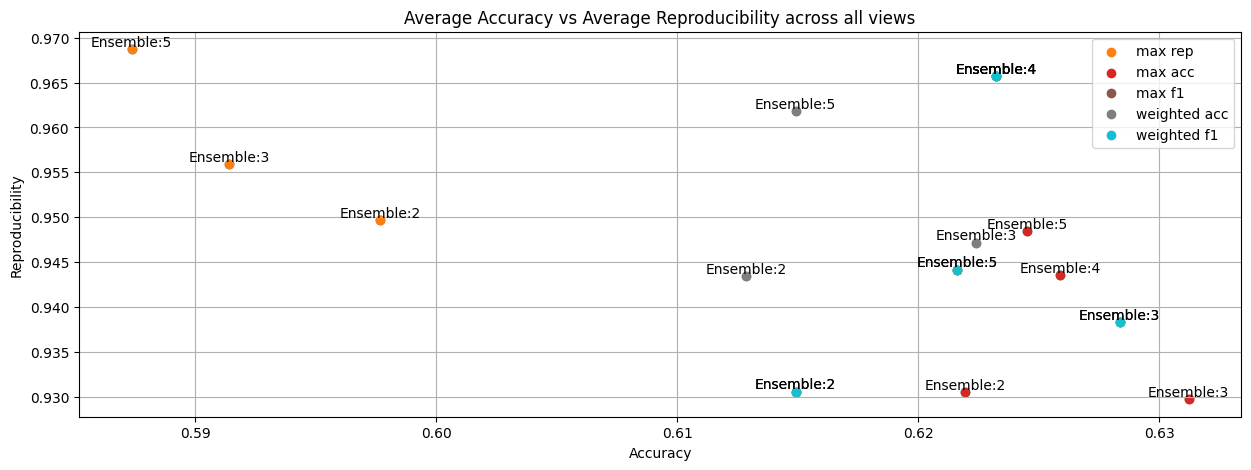

In [405]:
import matplotlib.pyplot as plt
import pandas as pd
from adjustText import adjust_text


for method in ['max rep', 'max acc', 'max f1', 'weighted acc', 'weighted f1']:
    # Assuming you have two DataFrames: df1 and df2
    # Let's say you want to plot column 'A' from df1 against column 'B' from df2
    labels = ["2", "3", "4", "5"]
    # Extract the columns of interest from the DataFrames
    x, y = df_acuracy.loc[method][4], df.loc[method][4]
    plt.scatter(x, y)

    # Create the scatter plot
    plt.scatter(x, y, label=method)

    # Add labels to each point
    for index, (i, j) in enumerate(zip(x, y)):
        plt.text(i, j, f'Ensemble:{labels[index]}', ha='center', va='bottom')
    # Customize the plot
    plt.xlabel('Accuracy')  # Add x-axis label
    plt.ylabel('Reproducibility')  # Add y-axis label
    plt.title(f'Average Accuracy vs Average Reproducibility across all views')  # Add title
    plt.grid()
    plt.legend()

plt.show()  # Show the plot

# COMPARISON WITH OTHER METHODS

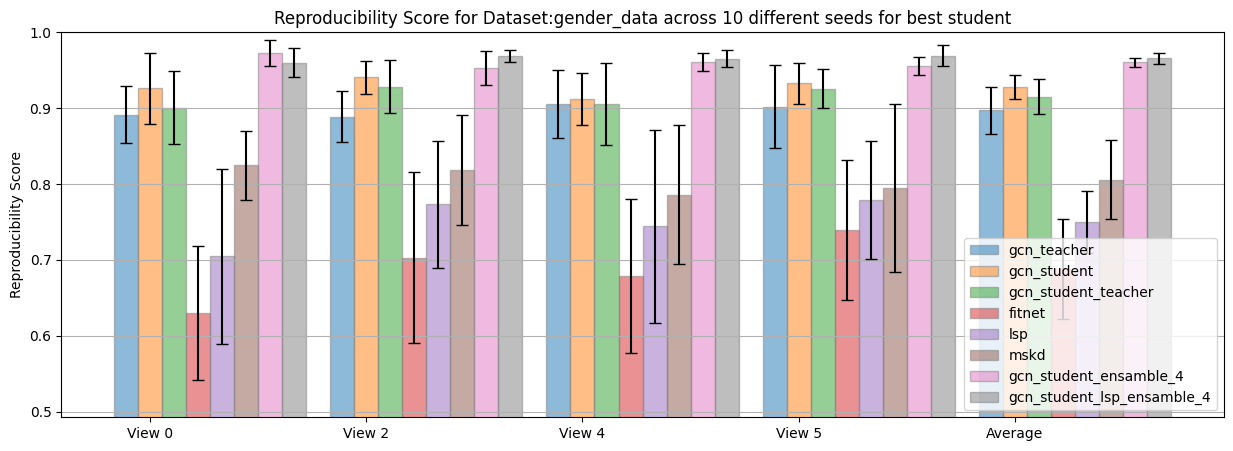

<Figure size 1500x500 with 0 Axes>

In [572]:
plot_bar_chart_reproducibility_mulitple_runs_student_specific(
    dataset="gender_data", 
    views=[0, 2, 4, 5], 
    models=[  
        "gcn", 
        "gcn_student",
        "gcn_student_teacher",
        "fitnet", 
        "lsp", 
        "mskd",
        "gcn_student_ensamble_4",
        "gcn_student_lsp_ensamble_4", 
    ], 
    CV=["3Fold", "5Fold", "10Fold"], 
    runs=[i for i in range(10)], 
    students=[
        [2,1,2,1],
        [2,1,2,1]
    ], 
    model_args= [
        gcn_args,
        gcn_student_args,
        gcn_student_args, 
        fitnet_student_args, 
        lsp_student_args, 
        mskd_student_args,
        gcn_student_ensamble_4_args,
        gcn_student_lsp_ensamble_4_args,
    ], 
    save_fig=False)

In [574]:
def reproducibility_mulitple_runs_student_specific(dataset, views, models, CV, runs, students=0, model_args=None):

    mean_all_runs = []
    views=[0, 2, 4, 5]
    runs=[i for i in range(10)]
    for run in runs:
        view_data_mean, _ = view_reproducibility_analysis_student_specific(dataset, models, CV, views, run, students=students, model_args=model_args)
        mean_all_runs.append(view_data_mean)

    mean_all_std = np.std(mean_all_runs, axis=0)
    mean_all_runs = np.mean(mean_all_runs, axis=0)
    
    return mean_all_runs, mean_all_std

In [688]:
mean_all_runs, mean_all_std = reproducibility_mulitple_runs_student_specific(
    dataset="gender_data", 
    views=[0, 2, 4, 5], 
    models=[  
        "gcn", 
        "gcn_student",
        "gcn_student_teacher",
        "fitnet", 
        "lsp", 
        "mskd",
        "gcn_student_ensamble_4",
        "gcn_student_lsp_ensamble_4", 
    ], 
    CV=["3Fold", "5Fold", "10Fold"], 
    runs=[i for i in range(10)], 
    students=[
        [2,1,2,1],
        [2,1,2,1]
    ], 
    model_args= [
        gcn_args,
        gcn_student_args,
        gcn_student_args, 
        fitnet_student_args, 
        lsp_student_args, 
        mskd_student_args,
        gcn_student_ensamble_4_args,
        gcn_student_lsp_ensamble_4_args,
    ])

In [689]:
mean_all_runs, mean_all_std

(array([[0.89138889, 0.88875   , 0.90597222, 0.90166667, 0.89694444],
        [0.92597222, 0.94041667, 0.91166667, 0.93291667, 0.92774306],
        [0.90069444, 0.92847222, 0.90569444, 0.92583333, 0.91517361],
        [0.63      , 0.70277778, 0.67861111, 0.73930556, 0.68767361],
        [0.70486111, 0.77305556, 0.74402778, 0.77916667, 0.75027778],
        [0.82444444, 0.81847222, 0.78611111, 0.79458333, 0.80590278],
        [0.97222222, 0.95305556, 0.96111111, 0.95527778, 0.96041667],
        [0.96      , 0.96888889, 0.965     , 0.96902778, 0.96572917]]),
 array([[0.03737531, 0.0338812 , 0.04468274, 0.05456336, 0.03138927],
        [0.04644811, 0.02196421, 0.03407848, 0.02696055, 0.01628206],
        [0.04762593, 0.0353021 , 0.05428566, 0.02627314, 0.02296767],
        [0.08833857, 0.11256   , 0.10113019, 0.09168571, 0.06585923],
        [0.11524975, 0.08329444, 0.12748767, 0.07741483, 0.04074999],
        [0.04523686, 0.07274398, 0.09169402, 0.11048338, 0.05176057],
        [0.0172132

In [690]:
reproducibility_frame = pd.DataFrame(mean_all_runs.T)

In [691]:
models=[  
    "gcn", 
    "gcn_student",
    "gcn_student_teacher",
    "fitnet", 
    "lsp", 
    "mskd",
    "gcn_student_ensamble_4",
    "gcn_student_lsp_ensamble_4", 
]
reproducibility_frame.columns = models

reproducibility_frame["delta teacher"] = ((reproducibility_frame["gcn_student_ensamble_4"] - reproducibility_frame["gcn"]) / reproducibility_frame["gcn"])*100
reproducibility_frame["delta student"] = ((reproducibility_frame["gcn_student_ensamble_4"] - reproducibility_frame["gcn_student"]) / reproducibility_frame["gcn_student"])*100

reproducibility_frame["lsp delta teacher"] = ((reproducibility_frame["gcn_student_lsp_ensamble_4"] - reproducibility_frame["gcn"]) / reproducibility_frame["gcn"])*100
reproducibility_frame["lsp delta student"] = ((reproducibility_frame["gcn_student_lsp_ensamble_4"] - reproducibility_frame["gcn_student"]) / reproducibility_frame["gcn_student"])*100

In [692]:
reproducibility_frame

,gcn,gcn_student,gcn_student_teacher,fitnet,lsp,mskd,gcn_student_ensamble_4,gcn_student_lsp_ensamble_4,delta teacher,delta student,lsp delta teacher,lsp delta student
0,0.891389,0.925972,0.900694,0.630000,0.704861,0.824444,0.972222,0.960000,9.068246,4.994750,7.697102,3.674816
1,0.888750,0.940417,0.928472,0.702778,0.773056,0.818472,0.953056,0.968889,7.235506,1.343967,9.017034,3.027618
2,0.905972,0.911667,0.905694,0.678611,0.744028,0.786111,0.961111,0.965000,6.086157,5.423522,6.515407,5.850091
3,0.901667,0.932917,0.925833,0.739306,0.779167,0.794583,0.955278,0.969028,5.945779,2.396903,7.470733,3.870776
4,0.896944,0.927743,0.915174,0.687674,0.750278,0.805903,0.960417,0.965729,7.076494,3.521838,7.668783,4.094465


In [727]:
from models.model_config import *

views=[0, 2, 4, 5]
CV=["3Fold", "5Fold", "10Fold"]
model = ["gcn_student_ensamble_4", "gcn_student_lsp_ensamble_4"]
runs = [i for i in range(10)]
dataset = "gender_data"
dataset_split="val"
analysis_type="model_assessment"
metrics = ["acc"]
model_args= [gcn_student_ensamble_4_args, gcn_student_lsp_ensamble_4_args]
best_student = [2,1,2,1]
best_student_4_lsp = [2,1,2,1]

view_mean = []
view_std = []
    
for best_student_i, view in enumerate(views):

    models = ["gcn", "gcn_student", "gcn_student_teacher", "fitnet", "lsp", "mskd"]
    mean_all_runs = []
    for run in [i for i in range(10)]:
        view_data_mean, _ = view_metric_analysis(models=models, CV=CV, view=view, run=run, metric="acc", dataset=dataset, 
                                                 dataset_split=dataset_split, analysis_type=analysis_type, model_args= [
                                                                                                                gcn_args,
                                                                                                                gcn_student_args,
                                                                                                                gcn_student_args, 
                                                                                                                fitnet_student_args, 
                                                                                                                lsp_student_args, 
                                                                                                                mskd_student_args
                                                                                                            ]
                                                                                                        )
        mean_all_runs.append(view_data_mean)

    mean_all_std = np.std(mean_all_runs, axis=0).squeeze()
    mean_all_runs = np.mean(mean_all_runs, axis=0).squeeze()

    index_student = best_student[best_student_i]

    model_mean = []
    model_std = []

    for i, model_arg in enumerate(model_args):
        mean, std = get_student_model_metric(dataset, model[i], CV, runs, analysis_type, dataset_split, view, model_arg)
        model_mean.append(mean[index_student])
        model_std.append(std[index_student])
        print(model_mean)
    
    for i, metric in enumerate(metrics):
        print("____________________________________________________")
        print(f"View: {view} Metric: {metric}")        
    

        mean_df = np.array(model_mean[0])[:,i]
        mean_df = mean_df[np.newaxis, :]
        
        std_df = np.array(model_std[0])[:,i]
        std_df = std_df[np.newaxis, :]
        
        final_mean_df = np.r_[mean_all_runs, mean_df]
        final_var_df = np.r_[mean_all_std, std_df]

        mean_df = np.array(model_mean[1])[:,i]
        mean_df = mean_df[np.newaxis, :]
    
        std_df = np.array(model_std[1])[:,i]
        std_df = std_df[np.newaxis, :]
        
        final_mean_df = np.r_[final_mean_df, mean_df]
        final_var_df = np.r_[final_var_df, std_df]

    view_mean.append(np.c_[ final_mean_df, np.mean(final_mean_df, axis=1)])
    view_std.append(np.c_[ final_var_df, np.std(final_var_df, axis=1)])

[array([[0.58498993, 0.40151253, 0.33257186, 0.56760362],
       [0.60351403, 0.49394975, 0.45161072, 0.57762236],
       [0.62130811, 0.50160861, 0.43956757, 0.61693361]])]
[array([[0.58498993, 0.40151253, 0.33257186, 0.56760362],
       [0.60351403, 0.49394975, 0.45161072, 0.57762236],
       [0.62130811, 0.50160861, 0.43956757, 0.61693361]]), array([[0.58412541, 0.39059821, 0.31724094, 0.56681338],
       [0.60165873, 0.48492607, 0.43726776, 0.57589278],
       [0.61812535, 0.48935002, 0.42299099, 0.61586573]])]
____________________________________________________
View: 0 Metric: acc
[array([[0.61169565, 0.53491624, 0.50921061, 0.56865458],
       [0.62065964, 0.56512957, 0.56625033, 0.56960544],
       [0.62909656, 0.5548826 , 0.53413514, 0.58639022]])]
[array([[0.61169565, 0.53491624, 0.50921061, 0.56865458],
       [0.62065964, 0.56512957, 0.56625033, 0.56960544],
       [0.62909656, 0.5548826 , 0.53413514, 0.58639022]]), array([[0.61184915, 0.53154754, 0.50172917, 0.57055421],
 

In [728]:
average_across_views = []
for i in range(4):
    average_across_views.append(view_mean[i][:,-1])

In [729]:
average_across_views_df = pd.DataFrame(average_across_views)
# Assuming you have a DataFrame named 'df'
average_across_views_df_mean = average_across_views_df.mean(axis=0)  # Calculate the mean of each row
average_across_views_df_mean = pd.DataFrame(average_across_views_df_mean).T  # Create a DataFrame from the row means

# Append the row mean DataFrame to the original DataFrame
average_across_views_df = average_across_views_df.append(average_across_views_df_mean, ignore_index=True)

# Display the DataFrame with the added row
average_across_views_df

,0,1,2,3,4,5,6,7
0,0.610109,0.577844,0.581616,0.607256,0.612096,0.621827,0.603271,0.601303
1,0.661582,0.637472,0.639818,0.642089,0.655798,0.657213,0.620484,0.619532
2,0.669069,0.632487,0.637550,0.651959,0.664259,0.665079,0.640926,0.640231
3,0.654419,0.636227,0.637657,0.644463,0.657846,0.657864,0.634214,0.631901
4,0.648795,0.621007,0.624160,0.636442,0.647500,0.650496,0.624724,0.623242


In [730]:
average_across_views_df = pd.DataFrame(average_across_views_df)
models=[  
    "gcn", 
    "gcn_student",
    "gcn_student_teacher",
    "fitnet", 
    "lsp", 
    "mskd",
    "gcn_student_ensamble_4",
    "gcn_student_lsp_ensamble_4", 
]
average_across_views_df.columns = models
average_across_views_df["delta teacher"] = ((average_across_views_df["gcn_student_ensamble_4"] - average_across_views_df["gcn"]) / average_across_views_df["gcn"])*100
average_across_views_df["delta student"] = ((average_across_views_df["gcn_student_ensamble_4"] - average_across_views_df["gcn_student"]) / average_across_views_df["gcn_student"])*100

average_across_views_df["lsp delta teacher"] = ((average_across_views_df["gcn_student_lsp_ensamble_4"] - average_across_views_df["gcn"]) / average_across_views_df["gcn"])*100
average_across_views_df["lsp delta student"] = ((average_across_views_df["gcn_student_lsp_ensamble_4"] - average_across_views_df["gcn_student"]) / average_across_views_df["gcn_student"])*100

In [731]:
average_across_views_df

,gcn,gcn_student,gcn_student_teacher,fitnet,lsp,mskd,gcn_student_ensamble_4,gcn_student_lsp_ensamble_4,delta teacher,delta student,lsp delta teacher,lsp delta student
0,0.610109,0.577844,0.581616,0.607256,0.612096,0.621827,0.603271,0.601303,-1.120861,4.400189,-1.443350,4.059694
1,0.661582,0.637472,0.639818,0.642089,0.655798,0.657213,0.620484,0.619532,-6.212046,-2.664872,-6.355913,-2.814180
2,0.669069,0.632487,0.637550,0.651959,0.664259,0.665079,0.640926,0.640231,-4.206279,1.334383,-4.310292,1.224355
3,0.654419,0.636227,0.637657,0.644463,0.657846,0.657864,0.634214,0.631901,-3.087506,-0.316367,-3.440980,-0.679948
4,0.648795,0.621007,0.624160,0.636442,0.647500,0.650496,0.624724,0.623242,-3.710125,0.598440,-3.938565,0.359778
